In [1]:
DATA_DIR = '/lustre/groups/ml01/workspace/louis.kuemmerle/projects/A1/data2/' # "./../"
DATA_VERSION = 'oct22'
RESULTS_DIR = '/lustre/groups/ml01/workspace/louis.kuemmerle/projects/A1/results/'
SHAM = True

########################################################################################
sham_str = '_wSham' if SHAM else ''

In [2]:
import os 
import numpy as np
import itertools
import scipy as sci
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

import scanpy as sc
import anndata as ann

from scipy.sparse import csr_matrix, issparse
import matplotlib
from matplotlib import rcParams
from matplotlib import colors


sc.settings.verbosity = 3
sc.logging.print_versions()

-----
anndata     0.7.5
scanpy      1.6.1
sinfo       0.3.1
-----
PIL                 8.1.0
anndata             0.7.5
anyio               NA
attr                20.3.0
babel               2.9.0
backcall            0.2.0
brotli              1.0.9
certifi             2020.12.05
cffi                1.14.4
chardet             4.0.0
cloudpickle         1.6.0
constants           NA
cycler              0.10.0
cython_runtime      NA
dask                2020.12.0
dateutil            2.8.1
decorator           4.4.2
future_fstrings     NA
get_version         2.1
google              NA
h5py                2.10.0
highs_wrapper       NA
idna                2.10
igraph              0.8.3
ipykernel           5.4.3
ipython_genutils    0.2.0
ipywidgets          7.6.3
jedi                0.18.0
jinja2              2.11.2
joblib              1.0.0
json5               NA
jsonschema          3.2.0
jupyter_server      1.2.1
jupyterlab_server   2.1.2
kiwisolver          1.3.1
legacy_api_wrap     1.2
leidenalg

In [40]:
import scvelo as scv
print(scv.__version__)

0.2.3


In [3]:
adata = sc.read(DATA_DIR+f'cellxgene_{DATA_VERSION}{sham_str}_umaps.h5ad')
adata = adata[adata.obs["level1"] == "neutrophil"]

/opt/python/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


---

In [6]:
adata_velo = sc.read(DATA_DIR+f'cellxgene_{DATA_VERSION}{sham_str}_loom_merged.h5ad')
adata_velo = adata_velo[adata.obs_names]

In [5]:
import scvelo as scv

In [7]:
del adata_velo.uns['neighbors']
del adata_velo.obsm['X_pca']
del adata_velo.varm['PCs']
del adata_velo.obsp

adata_velo.X = adata_velo.layers['spliced']
scv.pp.filter_and_normalize(adata_velo, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata_velo, n_pcs=30, n_neighbors=30)

scv.tl.recover_dynamics(adata_velo,n_jobs=24)    
scv.tl.velocity(adata_velo, mode='dynamical')
scv.tl.velocity_graph(adata_velo)

Filtered out 7700 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing PCA
    on highly variable genes
    with n_comps=30
    finished (0:00:12)
computing neighbors
    finished (0:01:24) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:11) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 24/64 cores)


  0%|          | 0/1375 [00:00<?, ?gene/s]

    finished (1:05:24) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:04:28) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:03:56) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [8]:
adata_velo.write(DATA_DIR+f"velo_data/cellxgene_{DATA_VERSION}{sham_str}_neutrophils.h5ad")

---

# Outline

compute velocities per conditions.
Based on the phase portraits we can evaluate which velocity projections actually look valid. The dynamic scvelo model 
leads to false results in some cases. The MCAo results fits best to pseudotime, neighborhood dependencies, and the
most important driver genes according to the phase portraits. This is why we choose the MCAo results as representative
scvelo result.



In [4]:
adata_velo = sc.read(DATA_DIR+f"velo_data/cellxgene_{DATA_VERSION}{sham_str}_neutrophils.h5ad")

In [19]:
adata_velo = adata_velo.copy()
adata_velo.obsm["X_umap_neutrophils"] = adata.obsm["X_umap_neutrophils"]
adata_velo.obs["level2"] = adata.obs["level2"]
adata_velo.uns['level2_colors'] = adata.uns['level2_colors']

In [16]:
adata_velo.obsm["X_umap_neutrophils"]

ArrayView([[-0.57494217,  5.64079523],
           [-1.65106666,  4.3811264 ],
           [-2.20320797, -2.14620662],
           ...,
           [ 8.82401371,  5.65406847],
           [ 8.72964764,  5.74091864],
           [ 5.78892756,  6.75983715]])

computing velocity embedding
    finished (0:00:12) --> added
    'velocity_umap_neutrophils', embedded velocity vectors (adata.obsm)


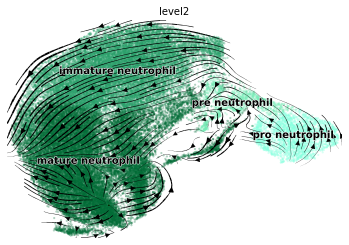

In [25]:
scv.pl.velocity_embedding_stream(adata_velo.copy(), basis='X_umap_neutrophils', color="level2",show=True) #,legend_loc='on data'

#### Condition wise velocities
(all three conditions together don't reflect the actual velocities well)

In [5]:
adata_velo = sc.read(DATA_DIR+f'cellxgene_{DATA_VERSION}{sham_str}_loom_merged.h5ad')
adata_velo = adata_velo[adata.obs_names]
adata_velo.obsm["X_umap_neutrophils"] = adata.obsm["X_umap_neutrophils"]
adata_velo.obs["level2"] = adata.obs["level2"]
adata_velo.uns['level2_colors'] = adata.uns['level2_colors']

for condition in ["Naive","Sham","MCAO"]:
    a = adata_velo[adata_velo.obs["condition"] == condition].copy()
    
    del a.uns['neighbors']
    del a.obsm['X_pca']
    del a.varm['PCs']
    del a.obsp
    
    a.X = a.layers['spliced']
    scv.pp.filter_and_normalize(a, min_shared_counts=20, n_top_genes=2000)
    scv.pp.moments(a, n_pcs=30, n_neighbors=30)
    
    scv.tl.recover_dynamics(a,n_jobs=48)    
    scv.tl.velocity(a, mode='dynamical')
    scv.tl.velocity_graph(a)    
    
    a.write(DATA_DIR+f"velo_data/cellxgene_{DATA_VERSION}{sham_str}_neutrophils_{condition}.h5ad")

Filtered out 10286 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing PCA
    on highly variable genes
    with n_comps=30
    finished (0:00:02)
computing neighbors
    finished (0:00:12) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 48/48 cores)


  0%|          | 0/990 [00:00<?, ?gene/s]

    finished (0:08:37) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:15) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:17) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
Filtered out 9609 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing PCA
    on highly variable genes
    with n_comps=30
    finished (0:00:01)
computing neighbors
    finished (0:00:03) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 48/48 cores)


  0%|          | 0/1067 [00:00<?, ?gene/s]

    finished (0:08:56) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:17) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:19) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
Filtered out 8314 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing PCA
    on highly variable genes
    with n_comps=30
    finished (0:00:06)
computing neighbors
    finished (0:00:17) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:05) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 48/48 cores)


  0%|          | 0/1284 [00:00<?, ?gene/s]

    finished (0:29:47) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:51) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:01:21) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:02) --> added
    'velocity_umap_neutrophils', embedded velocity vectors (adata.obsm)


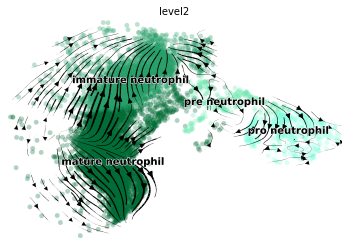

computing velocity embedding
    finished (0:00:02) --> added
    'velocity_umap_neutrophils', embedded velocity vectors (adata.obsm)


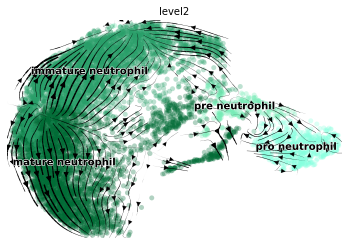

computing velocity embedding
    finished (0:00:07) --> added
    'velocity_umap_neutrophils', embedded velocity vectors (adata.obsm)


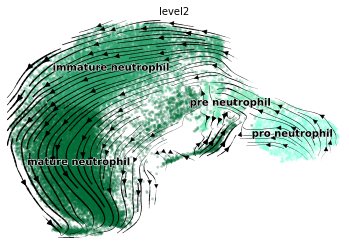

In [6]:
for condition in ["Naive","Sham","MCAO"]:
    adata_velo = sc.read(DATA_DIR+f"velo_data/cellxgene_{DATA_VERSION}{sham_str}_neutrophils_{condition}.h5ad")
    
    scv.pl.velocity_embedding_stream(adata_velo.copy(), basis='X_umap_neutrophils', color="level2",show=True) #,legend_loc='on data'

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors

plt.rcParams['figure.dpi'] = 150
SMALL_SIZE = 17
MEDIUM_SIZE = 19
BIGGER_SIZE = 21
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


computing velocity embedding
    finished (0:00:07) --> added
    'velocity_umap_neutrophils', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/scvelo_neutrophils_MCAO_region.png


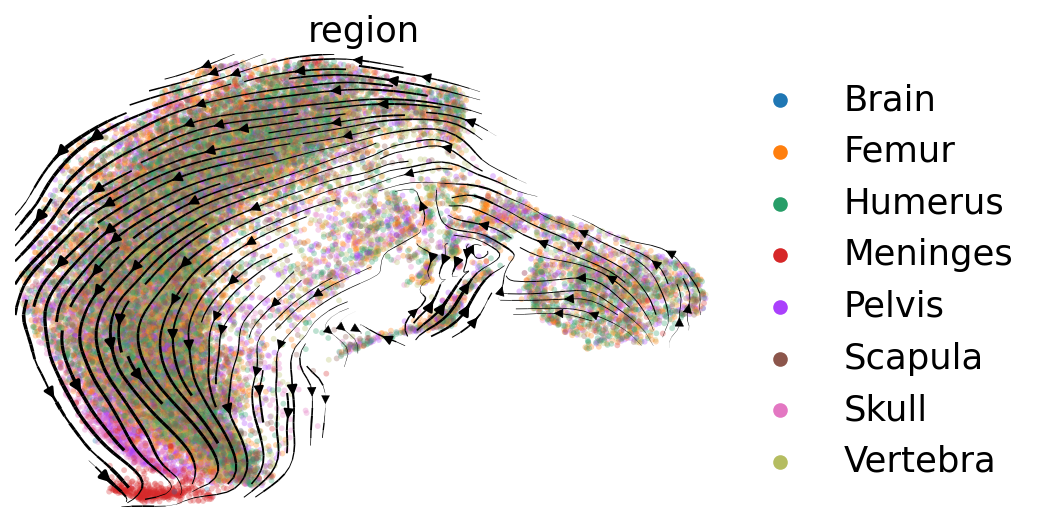

In [152]:
adata_velo = sc.read(DATA_DIR+f"velo_data/cellxgene_{DATA_VERSION}{sham_str}_neutrophils_MCAO.h5ad")

scv.pl.velocity_embedding_stream(adata_velo.copy(), basis='X_umap_neutrophils', color="region",show=True,legend_loc='right margin',
                                 save="neutrophils_MCAO_region.png")

computing velocity embedding
    finished (0:00:17) --> added
    'velocity_umap_neutrophils', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/scvelo_neutrophils_MCAO_level2.png


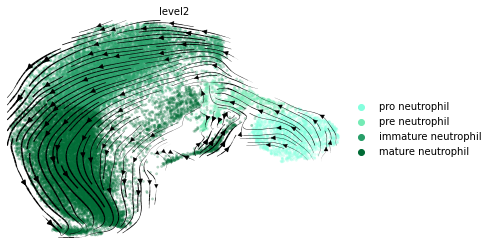

In [5]:
adata_velo = sc.read(DATA_DIR+f"velo_data/cellxgene_{DATA_VERSION}{sham_str}_neutrophils_MCAO.h5ad")

scv.pl.velocity_embedding_stream(adata_velo.copy(), basis='X_umap_neutrophils', color="level2",show=True,legend_loc='right margin',
                                 save="neutrophils_MCAO_level2.png")

saving figure to file ./figures/scvelo_S100a6_MCAO.png


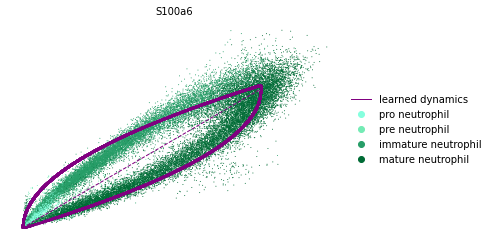

In [6]:
scv.pl.scatter(adata_velo, basis=["S100a6"], frameon=False, ncols=1, color='level2', legend_loc='right margin',save="S100a6_MCAO.png")

saving figure to file ./figures/scvelo_S100a6_Naive.png


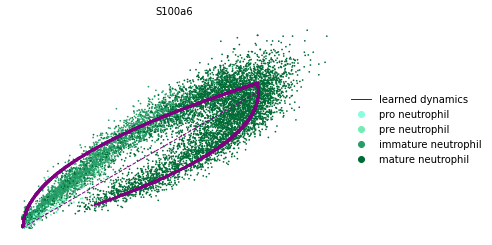

saving figure to file ./figures/scvelo_S100a6_Sham.png


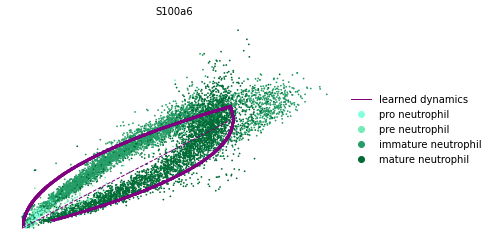

In [7]:
a_tmps = {}
for condition in ["Naive","Sham"]:
    a_tmps[condition] = sc.read(DATA_DIR+f"velo_data/cellxgene_{DATA_VERSION}{sham_str}_neutrophils_{condition}.h5ad")
    scv.pl.scatter(a_tmps[condition], basis=["S100a6"], frameon=False, ncols=1, color='level2', legend_loc='right margin',save=f"S100a6_{condition}.png")

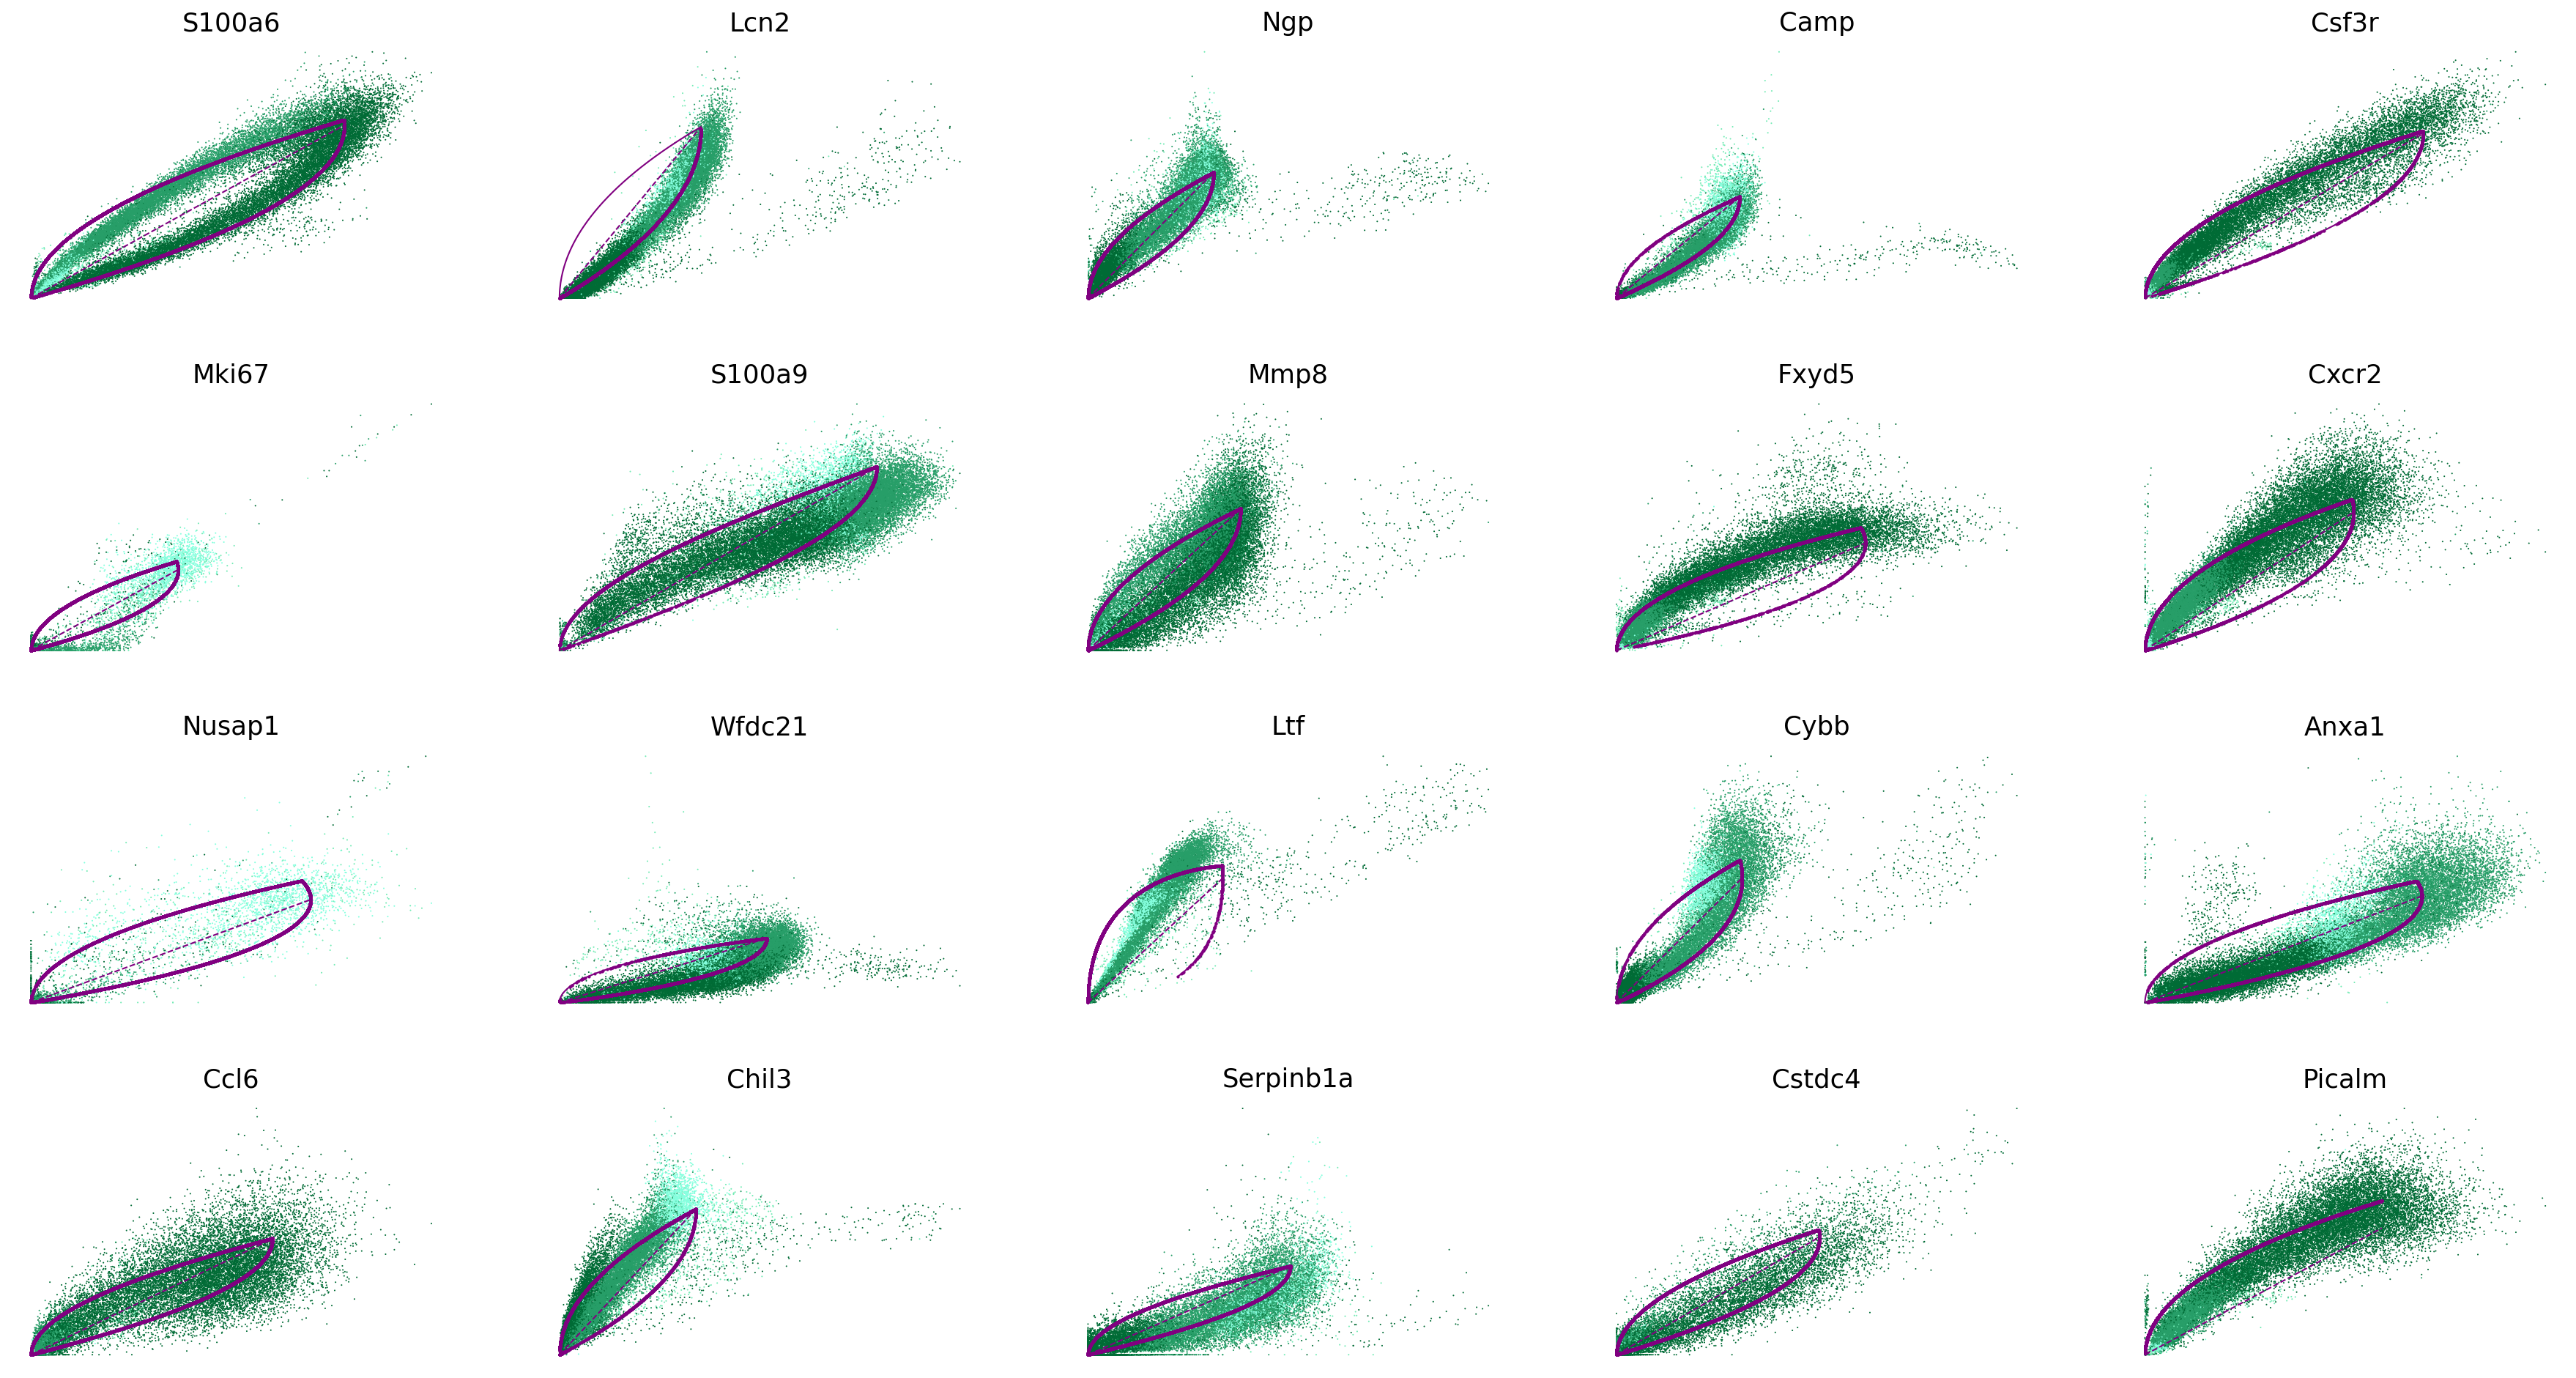

In [10]:
top_genes = adata_velo.var['fit_likelihood'].sort_values(ascending=False).index
scv.pl.scatter(adata_velo, basis=top_genes[:20], ncols=5, frameon=False, color='level2')

In [18]:
"Retnlg" in top_genes

False

In [19]:
"Retnlg" in adata_velo.var_names

False

In [ ]:
# ## argue ##
# shown MCAO only: 
#    - projections for all conditions at the same time are mixed up
#    - it's known that projections can be misleading, and especially that they point in wrong directions
#    - a double check with the driver gene's phase portraits is needed.
#    - we find crystal clear phase portraits for 2/3 driver genes in all conditions (Retnlg/S100a9/ more?)
#    - 

## Histogram over pseudotime

In [3]:
adata = sc.read(DATA_DIR+f'cellxgene_{DATA_VERSION}{sham_str}_umaps.h5ad')
adata = adata[adata.obs["level1"] == "neutrophil"]

a = adata[adata.obs["region"].isin(['Skull','Meninges','Vertebra','Scapula','Humerus','Pelvis','Femur'])].copy()

/opt/python/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Create csv files for pseudotime plots

In [26]:
for cond in ["Naive","Sham","MCAO"]:
    a = adata[(adata.obs["level1"] == "neutrophil") & 
              (adata.obs["condition"] == cond) &
              adata.obs["region"].isin(['Skull','Meninges','Vertebra','Scapula','Humerus','Pelvis','Femur']),
              adata.var["highly_variable"]].copy()
    sc.pp.pca(a)
    sc.pp.neighbors(a)
    sc.tl.umap(a)
    umap_0 = [term[0] for term in a.obsm['X_umap_neutrophils']]
    umap_1 = [term[1] for term in a.obsm['X_umap_neutrophils']]
    a.uns['iroot'] = np.flatnonzero(umap_0== max(umap_0))[0]
    sc.tl.dpt(a)    
    a.obs[["dpt_pseudotime","region"]].to_csv(f"./figures/pseudotime/obs_{cond}.csv")

/opt/python/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:06)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:09)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:28)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9976513  0.99549264 0.98502135 0.97976243 0.9739811
     0.9684365  0.9636849  0.95973927 0.95745707 0.95501965 0.9484149
     0.9424603  0.9394463  0.9351989 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)
computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


/opt/python/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:06)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:07)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:05)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.99732304 0.99333876 0.9899351  0.98194075 0.9786305
     0.97574306 0.97091943 0.9657125  0.9633843  0.96233076 0.96140933
     0.95715094 0.9513606  0.9509429 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)
computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


/opt/python/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:23)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:46)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:30)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9981219  0.99597234 0.9910331  0.9875259  0.9847682
     0.98276484 0.97890717 0.9748217  0.97321033 0.9706889  0.96974003
     0.96723795 0.96527797 0.9586369 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:06)
computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


histograms

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors

plt.rcParams['figure.dpi'] = 150
SMALL_SIZE = 13
MEDIUM_SIZE = 15
BIGGER_SIZE = 17
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [5]:
# Rename Skull to Calvaria
a.obs["region"].cat.rename_categories({'Skull': 'Calvaria'}, inplace=True)

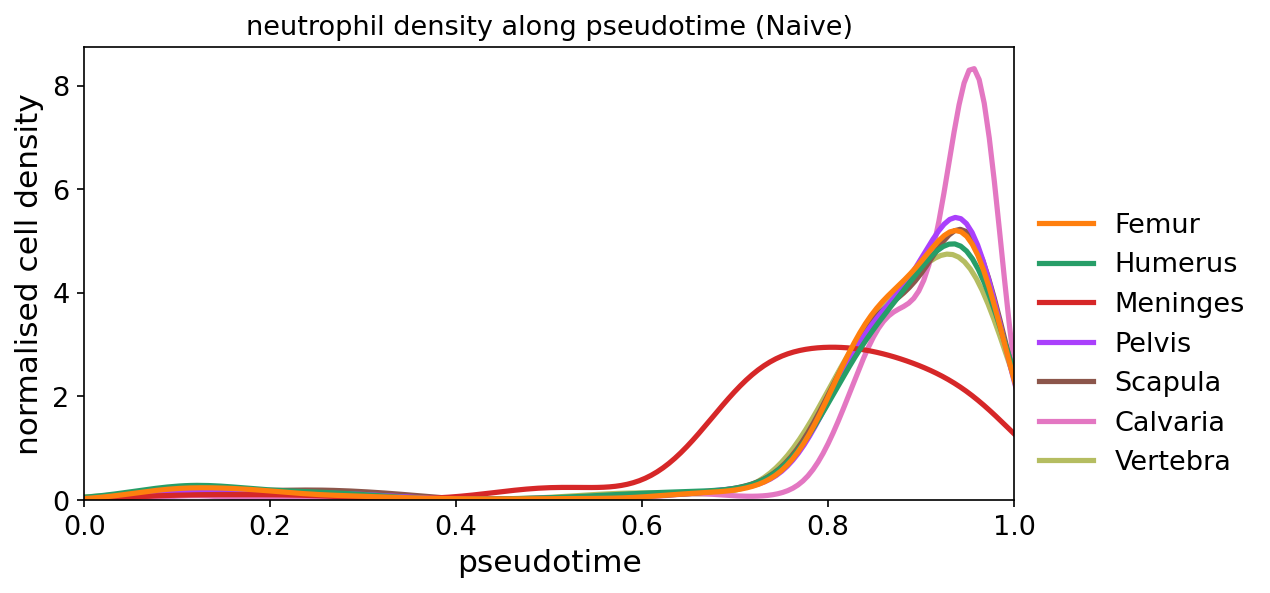

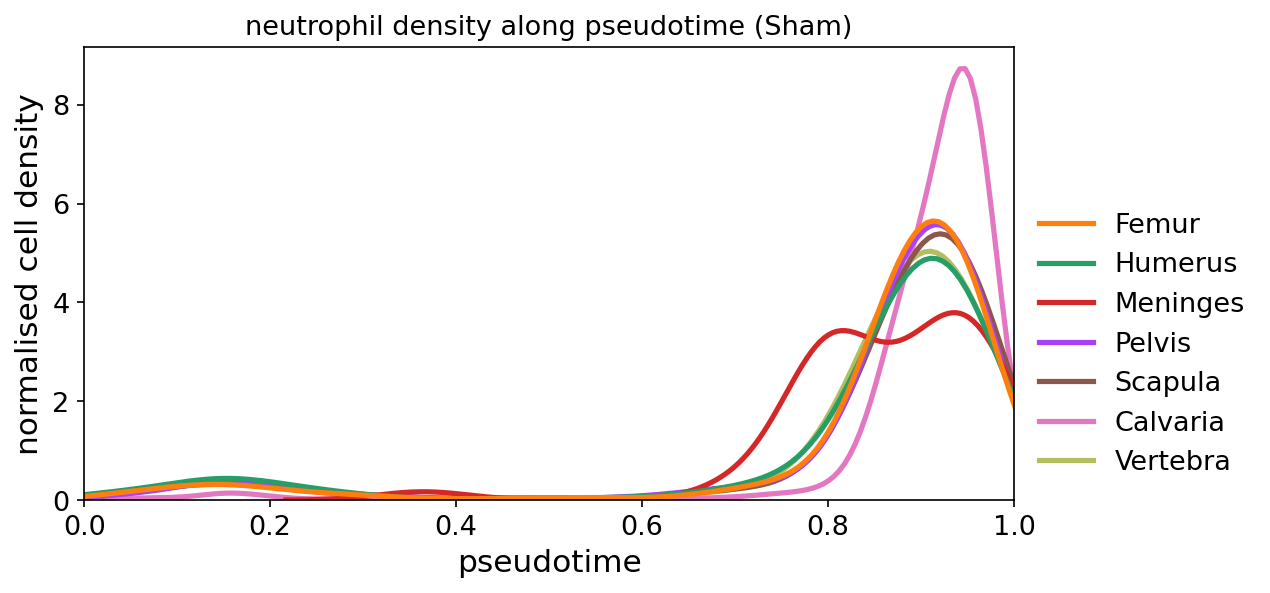

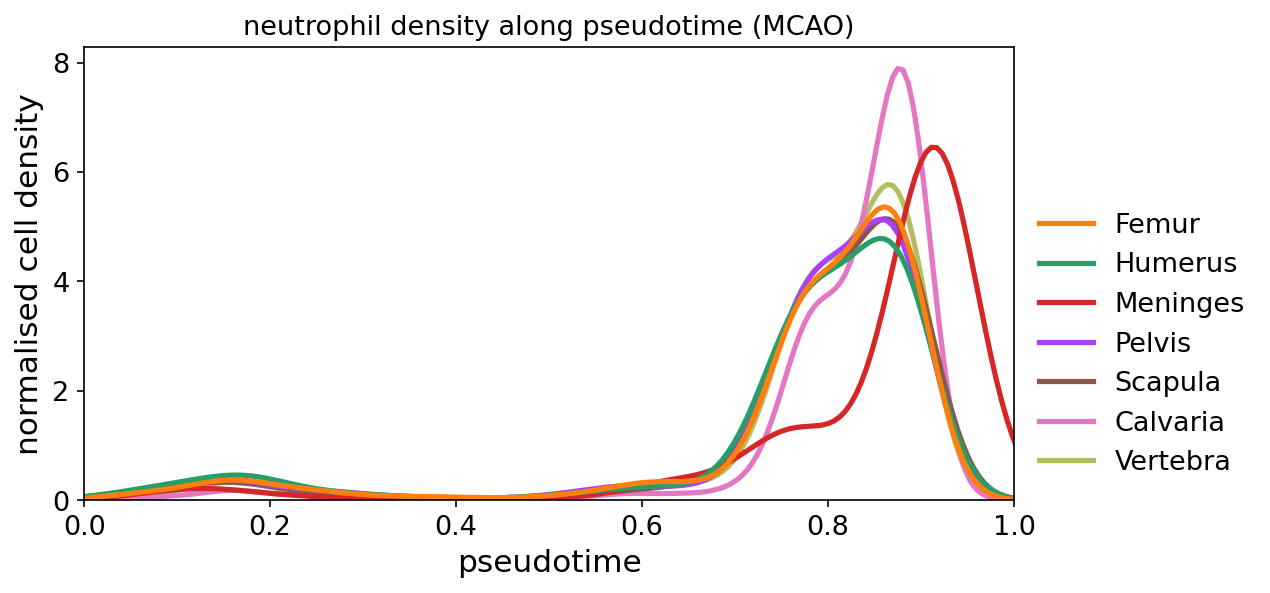

In [12]:
import matplotlib as mpl

region_color = {r:color for r,color in zip(a.obs["region"].cat.categories,a.uns["region_colors"])}

for cond in ["Naive","Sham","MCAO"]:
    plt.figure(figsize=(8,4))
    df = pd.read_csv(f"./figures/pseudotime/obs_{cond}.csv",index_col=0)
    df.loc[df["region"]=="Skull","region"] = "Calvaria"
    ax = sns.kdeplot(data=df,x='dpt_pseudotime',hue='region',hue_order=[r for r in region_color],
                     common_norm=False,palette=region_color,fill=False,legend=True,linewidth=2.5)
    plt.xlim([0,1])
    #ax.legend([r for r in region_color],frameon=False)
    legend = [l for l in ax.get_children() if isinstance(l,mpl.legend.Legend)][0]
    #ax.legend(ax.get_children()[-2].get_lines(),[r.get_text() for r in ax.get_children()[-2].get_texts()],frameon=False)
    ax.legend(legend.get_lines(),[r.get_text() for r in legend.get_texts()],frameon=False,
              loc='lower left', bbox_to_anchor=(1, 0))
    plt.ylabel("normalised cell density")
    plt.xlabel("pseudotime")
    plt.title(f"neutrophil density along pseudotime ({cond})")
    #plt.legend(frameon=False)
    #plt.legend().get_frame().set_facecolor('none')
    plt.gcf().savefig(f"./figures/pseudotime/cell_density_along_pseudotime_{cond}.png",transparent=True, bbox_inches = "tight")
    plt.show()


Plot umaps

In [86]:
for cond in ["Naive","Sham","MCAO"]:
    a = adata[(adata.obs["level1"] == "neutrophil") & 
              (adata.obs["condition"] == cond) &
              adata.obs["region"].isin(['Skull','Meninges','Vertebra','Scapula','Humerus','Pelvis','Femur']),
              adata.var["highly_variable"]].copy()
    df = pd.read_csv(f"./figures/pseudotime/obs_{cond}.csv",index_col=0)
    a.obs["dpt_pseudotime"] = df["dpt_pseudotime"]
    ax = sc.pl.embedding(a, basis="X_umap_neutrophils", color='dpt_pseudotime', size = 20, frameon=False, show=False)
    plt.title("")
    plt.gcf().savefig(f"./figures/pseudotime/umap_pseudotime_{cond}.png",transparent=True, bbox_inches = "tight")
    plt.close()

plot colorbar

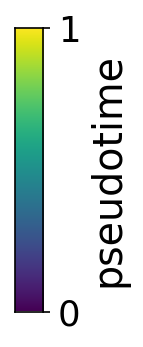

In [118]:
fig = plt.figure(figsize=(4,2.5))

cmap=plt.cm.viridis_r
colors = cmap(np.arange(cmap.N))
 
plt.imshow(colors[:,np.newaxis],extent=[0, 0.1, 0, 1])
plt.yticks(np.arange(2), ['0', '1']) 
plt.xticks([])
plt.gca().yaxis.tick_right()
plt.gca().yaxis.set_label_position("right")
plt.ylabel("pseudotime")
    
fig.savefig(f"./figures/pseudotime/pseudotime_cbar.pdf")

## PAGA

In [60]:
a = adata[adata.obs["region"] != "Brain"].copy()

In [61]:
a.obs["region_cond"] = a.obs["region"].astype(str) + "_" + a.obs["condition"].astype(str)

In [62]:
sc.tl.paga(a, groups="region_cond")

... storing 'region_cond' as categorical


running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:01)


In [97]:
cond_color = {cond:color for cond, color in zip(a.obs["condition"].cat.categories.tolist(),a.uns["condition_colors"].tolist())}
region_color = {region:color for region, color in zip(a.obs["region"].cat.categories.tolist(),a.uns["region_colors"].tolist())}

color = {key:({region_color[key.split("_")[0]]: 0.5, cond_color[key.split("_")[1]]  : 0.5,} 
              if region_color[key.split("_")[0]] != cond_color[key.split("_")[1]]
              else {region_color[key.split("_")[0]]: 1.0}) for key in a.obs["region_cond"].cat.categories
        }

--> added 'pos', the PAGA positions (adata.uns['paga'])


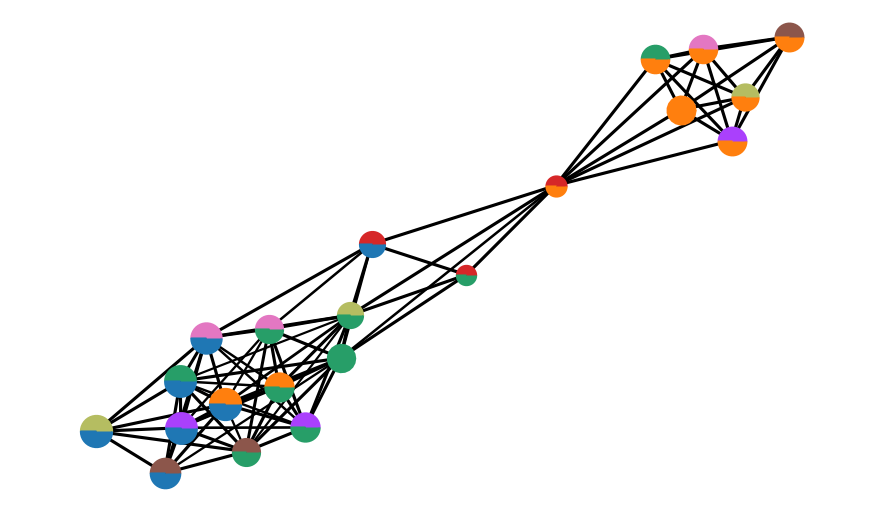

In [119]:
sc.pl.paga(a, 
           threshold=0.7, 
           color=color, 
           layout=None, 
           #layout_kwds=mappingproxy({}), 
           init_pos=None, 
           root=0, 
           labels=None,#np.repeat('', len(np.unique(adata.obs['region_cond']))),#None, 
           single_component=False, 
           solid_edges='connectivities', 
           dashed_edges=None, 
           transitions=None, 
           fontsize=10, 
           fontweight=None,#'bold', 
           fontoutline=None, 
           text_kwds={"alpha":0}, 
           node_size_scale=1.3, 
           node_size_power=0.2, 
           edge_width_scale=0.2,#0.15, 
           min_edge_width=0.1, 
           max_edge_width=50, 
           arrowsize=30, 
           title=None, 
           left_margin=0.01, 
           random_state=0, 
           pos=None, 
           normalize_to_color=False, 
           cmap=None, 
           cax=None, 
           colorbar=False, 
           #cb_kwds=mappingproxy({}), 
           frameon=False, 
           add_pos=True, 
           export_to_gexf=False, 
           use_raw=True, 
           colors=None, 
           groups=None, 
           plot=True, 
           show=None, 
           save="_neutrophils.png", 
           ax=None,
)

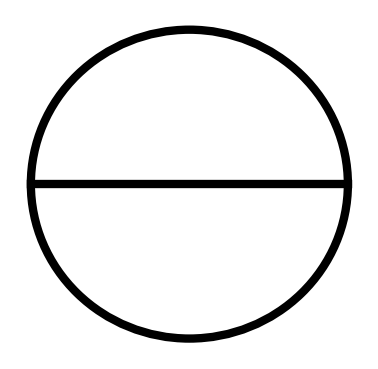

In [150]:
lw = 4
fig = plt.figure(figsize=(3,3))
circle=plt.Circle((0.5, 0.5), 0.2, edgecolor='black', facecolor="white", linewidth=lw)
plt.plot([0.3,0.7],[0.5,0.5],linewidth=lw,color="black")
plt.gca().add_patch(circle)
plt.axis("off")
fig.savefig("./figures/paga_legend.png",transparent=True)
plt.show()

## DE genes

We again go for the mean based combination DE test.    
This time we look at three groups: 
- Meninges
- Skull
- other bones   
   
but it's not totally fair to just pool all other bones together, instead we do have groups for all bones, but we check if there was a DE gene in Meninges and any of the other bones. 

In [84]:
bones=np.array(['Skull', 'Pelvis', 'Femur', 'Vertebra', 'Humerus'])
pool_bones = {"other":['Pelvis', 'Femur', 'Humerus']}

pooled = [b for key,bs in pool_bones.items() for b in bs]
new = [key for key in pool_bones]
np.array([b for b in bones if b not in pooled] + new)

array(['Skull', 'Vertebra', 'other'], dtype='<U8')

In [42]:
def get_mean_diff_based_df(adata,ct_key="level2",conditions=["Naive"],min_cells_per_bone=5,verbosity=2,
                           bones=np.array(['Skull', 'Pelvis', 'Femur', 'Vertebra', 'Humerus']),
                           pool_bones={}):
    """
    """
    
    # Basic definitions
    from tqdm.notebook import tqdm
    sc.settings.verbosity = 0
    keys = ["names","scores","pvals","pvals_adj","logfoldchanges"]
    adata_cond = adata[adata.obs["condition"].isin(conditions) & adata.obs["region"].isin(bones)].copy()
    dfs = []    

    # Pool bones to groups as defined in `pool_bones`
    if len(pool_bones) > 0:
        adata_cond.obs["region"] = adata_cond.obs["region"].astype(str)
        pooled = [b for key,bs in pool_bones.items() for b in bs]
        new = [key for key in pool_bones]
        bones = np.array([b for b in bones if b not in pooled] + new)
    for key in pool_bones:
        adata_cond.obs.loc[adata_cond.obs["region"].isin(pool_bones[key]),"region"] = key
    if len(pool_bones) > 0:
        adata_cond.obs["region"] = adata_cond.obs["region"].astype('category')
        
    # Filter out cell types
    tmp = pd.concat([adata_cond[adata_cond.obs["region"] == r].obs[ct_key].value_counts() for r in bones],axis=1)
    filtered_out_cts = tmp[(tmp.isnull() | (tmp < min_cells_per_bone)).any(axis=1)].index.tolist()
    celltypes = [ct for ct in adata_cond.obs[ct_key].unique().tolist() if ct not in filtered_out_cts]
    
    
    ############################
    # Tests for all cell types #
    ############################
    
    for ct in (tqdm(celltypes,desc="cell types") if (verbosity > 0) else celltypes):
        # Prepare adata
        a = adata_cond[adata_cond.obs[ct_key] == ct].copy()
    
        ##################################
        # Prepare df for given cell type #
        ##################################
        
        # Compute means
        tmp_means = []
        for r in bones:
            tmp_means.append(a[a.obs["region"] == r].X.mean(axis=0,dtype=np.float64))
            tmp_means[-1] = np.asarray(tmp_means[-1]).reshape(-1)[:,np.newaxis] if issparse(adata.X) else tmp_means[-1][:,np.newaxis]
        means = np.concatenate(tmp_means,axis=1)
        
        # For each gene get the combination of two bone groups defined by the largest mean expression difference between the ordered bones
        df = pd.DataFrame(index=a.var_names, columns = ["celltype"] + bones.tolist() + ["low","high"])
        combinations = np.zeros((adata.n_vars,len(bones)))
        n_regions_in_low_group = np.argmax(np.diff(np.sort(means,axis=1)),axis=1) + 1
        group_orders = np.argsort(means, axis=1)
        lower_border = [bones[group_orders[i][n_regions_in_low_group[i]-1]] for i in range(len(df))]
        higher_border = [bones[group_orders[i][n_regions_in_low_group[i]]] for i in range(len(df))]
        for i in range(len(n_regions_in_low_group)):
            combinations[i,group_orders[i][n_regions_in_low_group[i]:]] = 1
        # Save results in df
        df[bones] = combinations.astype(int)
        df["celltype"] = ct
        df["low"] = lower_border
        df["high"] = higher_border
        
        # Get bones groups combinations and add corresponding identifiers to each gene in df
        combs = [comb for r in range(1,len(bones)) for comb in itertools.combinations(bones, r)]
        df["combination"] = 0 # just to initialize
        for i,comb in enumerate(combs):
            comb_arr = np.array([1 if col in comb else 0 for col in df[bones].columns])
            filt = np.equal(df[bones].values, comb_arr[np.newaxis,:]).all(axis=1)
            df.loc[filt,"combination"] = i
            
        # Get combinations of the two bones at the highest mean difference border and add corresponding identifiers to each gene in df
        # (note, we call them permutations since e.g. Skull-Pelvis and Pelvis-Skull are both possible)
        perms = [perm for perm in itertools.permutations(bones, 2)]
        df["permutation"] = 0
        for i,perm in enumerate(perms):
            filt = (df["low"] == perm[0]) & (df["high"] == perm[1])
            df.loc[filt,"permutation"] = i
            
            
        #############
        # Run Tests #
        #############
        df_results = pd.DataFrame(index=df.index, columns = [f"{key}_{k}" for k in range(2) for key in keys if key != "names"])
        
        # Combinations of two groups of bones
        #for i,comb in enumerate(tqdm(combs,desc="test1: bone groups combinations")):
        for i,comb in enumerate((tqdm(combs,desc="test1: bone groups combinations") if (verbosity > 1) else combs)):
            
            genes = df.loc[df["combination"] == i].index.values
            if len(genes) > 0:
                group = list(comb)
                
                a.obs["tmp"] = "not_in_group"
                a.obs.loc[a.obs["region"].isin(group),"tmp"] = "in_group" 
                a.obs["tmp"] = a.obs["tmp"].astype('category')
                
                try:
                    rank_genes_results = sc.tl.rank_genes_groups(a[:,genes], 
                                            groupby="tmp", 
                                            groups=["in_group"], 
                                            reference="rest",
                                            n_genes=None, 
                                            rankby_abs=False, 
                                            pts=False, 
                                            key_added=None, 
                                            copy=True, 
                                            method='t-test_overestim_var', 
                                            corr_method='benjamini-hochberg', 
                                            ).uns["rank_genes_groups"]    
                    tmp_df = pd.concat([pd.DataFrame(rank_genes_results[key]).rename({"in_group": f"{key}_0"}, axis=1) for key in keys],axis=1)
                    tmp_df = tmp_df.rename({"names_0": "gene"}, axis=1)  
                    tmp_df = tmp_df.set_index("gene")
                    df_results.loc[tmp_df.index,tmp_df.columns] = tmp_df[tmp_df.columns]
                except Exception:
                    print(f"Group {group} vs rest: Couldn't compute test for cell type {ct}. (this should actually not happen!)")  
        
        # Combination of low and high bones (since order plays a role we call them permutations)        
        #for i,perm in enumerate(tqdm(perms,desc="test2: low high combinations")):
        for i,perm in enumerate((tqdm(perms,desc="test2: low high combinations") if (verbosity > 1) else perms)):            
        
            genes = df.loc[df["permutation"] == i].index.values
            if len(genes) > 0:            
                high = [perm[1]]
                reference = list(perm)
                
                try:
                    rank_genes_results = sc.tl.rank_genes_groups(a[a.obs["region"].isin(reference),genes], 
                                            groupby="region", 
                                            groups=high, 
                                            reference="rest",
                                            n_genes=None, 
                                            rankby_abs=False, 
                                            pts=False, 
                                            key_added=None, 
                                            copy=True, 
                                            method='t-test_overestim_var', 
                                            corr_method='benjamini-hochberg', 
                                            ).uns["rank_genes_groups"]    
                    tmp_df = pd.concat([pd.DataFrame(rank_genes_results[key]).rename({high[0]: f"{key}_1"}, axis=1) for key in keys],axis=1)
                    tmp_df = tmp_df.rename({"names_1": "gene"}, axis=1)  
                    tmp_df = tmp_df.set_index("gene")
                    df_results.loc[tmp_df.index,tmp_df.columns] = tmp_df[tmp_df.columns]
                except Exception:
                    print(f"Low {perm[0]} vs high {perm[1]}: Couldn't compute test for cell type {ct}. (this should actually not happen!)")
            
        # Get minimums/maximum of the two tests
        for key in ["pvals","pvals_adj"]:
            df[key] = df_results[[f"{key}_{i}" for i in range(2)]].max(axis=1)
        for key in ["scores","logfoldchanges"]: # we're only interested in positive values, so it doesn't matter that we also take the min for negative values
            df[key] = df_results[[f"{key}_{i}" for i in range(2)]].min(axis=1)  
            
        dfs.append(df)
    return pd.concat(dfs,axis=0)

In [19]:
df = get_mean_diff_based_df(adata,ct_key="level2",conditions=["Naive"],min_cells_per_bone=5,verbosity=2,
                            bones=np.array(['Meninges','Skull', 'Pelvis', 'Femur', 'Vertebra', 'Humerus']))

cell types:   0%|          | 0/3 [00:00<?, ?it/s]

test1: bone groups combinations:   0%|          | 0/62 [00:00<?, ?it/s]

test2: low high combinations:   0%|          | 0/30 [00:00<?, ?it/s]

test1: bone groups combinations:   0%|          | 0/62 [00:00<?, ?it/s]

test2: low high combinations:   0%|          | 0/30 [00:00<?, ?it/s]

test1: bone groups combinations:   0%|          | 0/62 [00:00<?, ?it/s]

test2: low high combinations:   0%|          | 0/30 [00:00<?, ?it/s]

In [26]:
df[(df["pvals_adj"] < 0.05) & (df["logfoldchanges"] > 0.5) & (df["combination"] == 6)]

celltype Meninges Skull Pelvis Femur Vertebra Humerus  \
index                                                                       
Vps37b     mature neutrophil        1     1      0     0        0       0   
Ndufa12    mature neutrophil        1     1      0     0        0       0   
Bcl2a1b    mature neutrophil        1     1      0     0        0       0   
Phlda1   immature neutrophil        1     1      0     0        0       0   
Dhrs11   immature neutrophil        1     1      0     0        0       0   
Ankrd9   immature neutrophil        1     1      0     0        0       0   

              low   high  combination  permutation         pvals  \
index                                                              
Vps37b     Pelvis  Skull            6           11  2.874342e-11   
Ndufa12  Vertebra  Skull            6           21  2.318692e-07   
Bcl2a1b     Femur  Skull            6           16  3.723793e-05   
Phlda1   Vertebra  Skull            6           21  5.060143e-04   
Dhrs11   Vertebra  Skull            6           21  7.213626e-04   
Ankrd9      Femur  Skull            6           16  4.910693e-04   

            pvals_adj    scores  logfoldchanges  
index                                            
Vps37b   3.046803e-09  6.688623        0.976180  
Ndufa12  2.086823e-06  5.190156        1.449447  
Bcl2a1b  1.593783e-03  4.133146        1.525562  
Phlda1   6.148073e-03  3.491451        0.524414  
Dhrs11   7.967777e-03  3.394816        0.902987  
Ankrd9   3.009830e-02  3.499984        0.728378

In [23]:
df[(df["pvals_adj"] < 0.05) & (df["logfoldchanges"] > 1.2) & (df["combination"] != 61)]

celltype Meninges Skull Pelvis Femur Vertebra Humerus  \
index                                                                       
Coq10b     mature neutrophil        0     1      0     0        0       0   
Ptgs2      mature neutrophil        0     1      0     0        0       0   
Atf3       mature neutrophil        0     1      0     0        0       0   
G0s2       mature neutrophil        0     1      0     0        0       0   
Thbs1      mature neutrophil        0     1      0     0        0       0   
Gla        mature neutrophil        0     1      0     0        0       0   
Cxcl2      mature neutrophil        0     1      0     0        0       0   
Hcar2      mature neutrophil        0     1      0     0        0       0   
Tubgcp2    mature neutrophil        0     1      1     1        0       1   
Ndufa12    mature neutrophil        1     1      0     0        0       0   
Acod1      mature neutrophil        0     1      0     0        0       0   
Bcl2a1d    mature neutrophil        0     1      0     0        0       0   
Bcl2a1b    mature neutrophil        1     1      0     0        0       0   
Ccrl2      mature neutrophil        0     1      0     0        0       0   
Csrnp1     mature neutrophil        0     1      0     0        0       0   
Osm        mature neutrophil        0     1      0     0        0       0   
Ccl4       mature neutrophil        0     1      0     0        0       0   
Cwc25      mature neutrophil        0     1      0     0        0       0   
Fos        mature neutrophil        0     1      0     0        0       0   
Apol8      mature neutrophil        0     1      0     0        0       0   
Maff       mature neutrophil        0     1      0     0        0       0   
Pim3       mature neutrophil        0     1      0     0        0       0   
Nr4a1      mature neutrophil        0     1      0     0        0       0   
Cdip1      mature neutrophil        0     1      0     0        0       0   
Ets2       mature neutrophil        0     1      0     0        0       0   
Sik1       mature neutrophil        0     1      0     0        0       0   
Trem1      mature neutrophil        0     1      0     0        0       0   
Gm4707     mature neutrophil        0     1      0     0        0       0   
Egr1       mature neutrophil        0     1      0     0        0       0   
Cd14       mature neutrophil        0     1      0     0        0       0   
Ptgs2    immature neutrophil        0     1      0     0        0       0   
Thbs1    immature neutrophil        0     1      0     0        0       0   
Snai1    immature neutrophil        0     1      0     0        0       0   
Srgn     immature neutrophil        0     1      0     0        0       0   
Osm      immature neutrophil        0     1      0     0        0       0   
Apol8    immature neutrophil        0     1      0     0        0       0   
Nr4a1    immature neutrophil        0     1      0     0        0       0   
Krt81    immature neutrophil        0     1      0     0        0       0   
Ets2     immature neutrophil        0     1      0     0        0       0   
Cd14     immature neutrophil        0     1      0     0        0       0   
Sdhc          pre neutrophil        0     0      1     1        1       1   
Rcc2          pre neutrophil        0     0      1     1        1       1   
Ski           pre neutrophil        0     0      1     1        1       1   
Taf6          pre neutrophil        0     1      1     1        0       1   
Pa2g4         pre neutrophil        0     0      1     1        1       1   
Tspan14       pre neutrophil        0     0      1     1        1       1   
Atp1b3        pre neutrophil        0     0      1     1        1       1   

              low     high  combination  permutation          pvals  \
index                                                                 
Coq10b      Femur    Skull            1           16   8.641150e-21   
Ptgs2    Vertebra    Skull       

In [18]:
df[(df["pvals_adj"] < 0.05) & (df["logfoldchanges"] > 2)]

celltype Skull Pelvis Femur Vertebra Humerus  \
index                                                                    
Ptgs2            mature neutrophil     1      0     0        0       0   
Atf3             mature neutrophil     1      0     0        0       0   
Tubgcp2          mature neutrophil     1      1     1        0       1   
Acod1            mature neutrophil     1      0     0        0       0   
Nr4a1            mature neutrophil     1      0     0        0       0   
Egr1             mature neutrophil     1      0     0        0       0   
Ptgs2          immature neutrophil     1      0     0        0       0   
Snai1          immature neutrophil     1      0     0        0       0   
Apol8          immature neutrophil     1      0     0        0       0   
Krt81          immature neutrophil     1      0     0        0       0   
Rpap1               pro neutrophil     0      1     1        1       1   
P2ry1               pro neutrophil     0      1     1        1       1   
Cnr2                pro neutrophil     0      1     1        1       1   
2610001J05Rik       pro neutrophil     0      1     1        1       1   
Tmem143             pro neutrophil     0      1     1        1       1   
Mrpl46              pro neutrophil     0      1     1        1       1   
Thap12              pro neutrophil     0      1     1        1       1   
Xkr5                pro neutrophil     0      1     1        1       1   
Prmt9               pro neutrophil     0      1     1        1       1   
Ccar2               pro neutrophil     0      1     1        1       1   
Pigs                pro neutrophil     0      1     1        1       1   
Tbce                pro neutrophil     0      1     1        1       1   
Zbtb25              pro neutrophil     0      1     1        1       1   
Zbtb1               pro neutrophil     0      1     1        1       1   
H1f0                pro neutrophil     0      1     1        1       1   
Fbxw4               pro neutrophil     0      1     1        1       1   

                    low     high  combination  permutation         pvals  \
index                                                                      
Ptgs2          Vertebra    Skull            0           12  3.039382e-44   
Atf3           Vertebra    Skull            0           12  3.235456e-17   
Tubgcp2        Vertebra    Skull           26           12  9.454799e-04   
Acod1            Pelvis    Skull            0            4  1.513989e-12   
Nr4a1          Vertebra    Skull            0           12  1.697430e-37   
Egr1           Vertebra    Skull            0           12  2.775881e-53   
Ptgs2          Vertebra    Skull            0           12  5.034684e-04   
Snai1           Humerus    Skull            0           16  8.014752e-05   
Apol8          Vertebra    Skull            0           12  2.999982e-03   
Krt81          Vertebra    Skull            0           12  2.888101e-04   
Rpap1             Skull    Femur           29            1  1.292220e-03   
P2ry1             Skull  Humerus           29            3  7.212790e-04   
Cnr2              Skull  Humerus           29            3  1.345540e-03   
2610001J05Rik     Skull  Humerus           29            3  3.094446e-04   
Tmem143           Skull    Femur           29            1  1.305991e-03   
Mrpl46            Skull  Humerus           29            3  5.426132e-05   
Thap12            Skull    Femur           29            1  7.506486e-05   
Xkr5              Skull    Femur           29            1  1.364442e-05   
Prmt9             Skull    Femur           29            1  1.506173e-06   
Ccar2             Skull   Pelvis           29            0  1.166809e-06   
Pigs              Skull    Femur           29            1  3.243489e-04   
Tbce              Skull  Humerus           29            3  1.157089e-03   
Zbtb25            Skull  Humerus           29            3  7.198774e-04   
Zbtb1             Skull  Humerus           29        

In [43]:
tmp = df[(df["pvals_adj"] < 0.05) & (df["logfoldchanges"] > 0.5)]#1.0)]#0.5)]
regions=np.array(['Meninges','Skull', 'Pelvis', 'Femur', 'Vertebra', 'Humerus'])

sets = [set(tmp.loc[tmp[r].astype(bool)].index.tolist()) for r in regions]

In [36]:
tmp["combination"].value_counts()

61    4152
1       53
55       6
0        2
52       2
6        2
23       1
Name: combination, dtype: int64

In [64]:
combinations = {"0":"only Meninges","1":"only Skull",
                "4":"only Vertebra",
                "6":"Meninges + Skull",
                "13":"Skull + Vertebra",
                "23": "Meninges + Skull + Vertebra",
                "52":"not Meninges + not Vertebra",
                "55":"not Meninges + not Skull",
                "60":"not Skull",
                "61":"not Meninges",
               }

In [59]:
tmp2 = pd.DataFrame(tmp["combination"].value_counts())
tmp2["name"] = tmp2.index.map(lambda x: combinations[str(x)])

In [65]:
tmp2["name"] = tmp2.index.map(lambda x: combinations[str(x)])

In [66]:
tmp2

combination                         name
61         4825                 not Meninges
1           100                   only Skull
0            10                only Meninges
6             6             Meninges + Skull
55            6     not Meninges + not Skull
52            4  not Meninges + not Vertebra
23            3  Meninges + Skull + Vertebra
13            2             Skull + Vertebra
4             1                only Vertebra
60            1                    not Skull

In [31]:
tmp2 = tmp["combination"].value_counts()

61    4825
1      100
0       10
6        6
55       6
52       4
23       3
13       2
4        1
60       1
Name: combination, dtype: int64

In [55]:
for comb in tmp["combination"].unique():
    display(tmp.loc[tmp["combination"] == comb].iloc[[0]])

celltype Meninges Skull Pelvis Femur Vertebra Humerus  \
index                                                                    
Mrpl15  mature neutrophil        0     1      1     1        1       1   

             low   high  combination  permutation     pvals  pvals_adj  \
index                                                                    
Mrpl15  Meninges  Skull           61            0  0.000317   0.005637   

          scores  logfoldchanges  
index                             
Mrpl15  3.611946       22.754295

celltype Meninges Skull Pelvis Femur Vertebra Humerus    low  \
index                                                                           
Coq10b  mature neutrophil        0     1      0     0        0       0  Femur   

         high  combination  permutation         pvals     pvals_adj    scores  \
index                                                                           
Coq10b  Skull            1           16  8.641150e-21  1.849206e-18  9.449514   

        logfoldchanges  
index                   
Coq10b        1.301487

celltype Meninges Skull Pelvis Femur Vertebra Humerus  \
index                                                                    
Vps37b  mature neutrophil        1     1      0     0        0       0   

           low   high  combination  permutation         pvals     pvals_adj  \
index                                                                         
Vps37b  Pelvis  Skull            6           11  2.874342e-11  3.046803e-09   

          scores  logfoldchanges  
index                             
Vps37b  6.688623         0.97618

celltype Meninges Skull Pelvis Femur Vertebra Humerus  \
index                                                                    
Hbb-bt  mature neutrophil        0     1      1     1        0       1   

             low   high  combination  permutation         pvals     pvals_adj  \
index                                                                           
Hbb-bt  Vertebra  Skull           52           21  9.908439e-16  1.226169e-14   

          scores  logfoldchanges  
index                             
Hbb-bt  8.088493        0.853313

celltype Meninges Skull Pelvis Femur Vertebra Humerus  \
index                                                                   
Uba52  mature neutrophil        1     1      0     0        1       0   

           low   high  combination  permutation         pvals  pvals_adj  \
index                                                                      
Uba52  Humerus  Skull           23           26  2.685195e-08   0.000006   

         scores  logfoldchanges  
index                            
Uba52  5.580204        0.652633

celltype Meninges Skull Pelvis Femur Vertebra Humerus    low  \
index                                                                           
Zfp207  mature neutrophil        1     0      1     1        1       1  Skull   

           high  combination  permutation     pvals  pvals_adj    scores  \
index                                                                      
Zfp207  Humerus           60            9  0.000231   0.023568  3.689176   

        logfoldchanges  
index                   
Zfp207        0.548337

celltype Meninges Skull Pelvis Femur Vertebra Humerus  \
index                                                                     
H3f3a  immature neutrophil        1     0      0     0        0       0   

         low      high  combination  permutation     pvals  pvals_adj  \
index                                                                   
H3f3a  Femur  Meninges            0           15  0.000058   0.010385   

         scores  logfoldchanges  
index                            
H3f3a  4.496553        0.832463

celltype Meninges Skull Pelvis Femur Vertebra Humerus  \
index                                                                     
Eml2   immature neutrophil        0     0      0     0        1       0   

          low      high  combination  permutation     pvals  pvals_adj  \
index                                                                    
Eml2   Pelvis  Vertebra            4           13  0.000813   0.045227   

         scores  logfoldchanges  
index                            
Eml2   3.362214        0.621701

celltype Meninges Skull Pelvis Femur Vertebra Humerus  \
index                                                                      
Nfkbiz  immature neutrophil        0     1      0     0        1       0   

           low      high  combination  permutation     pvals  pvals_adj  \
index                                                                     
Nfkbiz  Pelvis  Vertebra           13           13  0.000009   0.001275   

          scores  logfoldchanges  
index                             
Nfkbiz  4.468071        0.864762

celltype Meninges Skull Pelvis Femur Vertebra Humerus       low  \
index                                                                          
Sdhc   pre neutrophil        0     0      1     1        1       1  Meninges   

         high  combination  permutation     pvals  pvals_adj    scores  \
index                                                                    
Sdhc   Pelvis           55            1  0.010206   0.031202  2.657428   

       logfoldchanges  
index                  
Sdhc         2.851384

In [44]:
tmp.loc[tmp["combination"] == 0]

celltype Meninges Skull Pelvis Femur Vertebra Humerus  \
index                                                                        
H3f3a     immature neutrophil        1     0      0     0        0       0   
S100a8    immature neutrophil        1     0      0     0        0       0   
S100a9    immature neutrophil        1     0      0     0        0       0   
Sh3bgrl3  immature neutrophil        1     0      0     0        0       0   
Hp        immature neutrophil        1     0      0     0        0       0   
Lgals3    immature neutrophil        1     0      0     0        0       0   
Ubb       immature neutrophil        1     0      0     0        0       0   
Pfn1      immature neutrophil        1     0      0     0        0       0   
Ncf4      immature neutrophil        1     0      0     0        0       0   
Prdx5     immature neutrophil        1     0      0     0        0       0   

              low      high  combination  permutation     pvals  pvals_adj  \
index                                                                        
H3f3a       Femur  Meninges            0           15  0.000058   0.010385   
S100a8      Femur  Meninges            0           15  0.000010   0.004798   
S100a9    Humerus  Meninges            0           25  0.000058   0.030125   
Sh3bgrl3    Femur  Meninges            0           15  0.000168   0.016976   
Hp        Humerus  Meninges            0           25  0.000038   0.030125   
Lgals3      Femur  Meninges            0           15  0.000093   0.016372   
Ubb         Femur  Meninges            0           15  0.000197   0.016372   
Pfn1        Femur  Meninges            0           15  0.000006   0.004798   
Ncf4        Femur  Meninges            0           15  0.000395   0.047797   
Prdx5       Femur  Meninges            0           15  0.000055   0.012534   

            scores  logfoldchanges  
index                               
H3f3a     4.496553        0.832463  
S100a8    5.062281        0.782331  
S100a9    4.496879        0.705972  
Sh3bgrl3  4.152398        0.868152  
Hp        4.701543        1.054283  
Lgals3    4.401536        0.873944  
Ubb       4.100738        1.089168  
Pfn1      5.236009        0.817385  
Ncf4      3.942044        0.968510  
Prdx5     4.517403        0.772514

In [40]:
tmp.loc[tmp["combination"] == 6]

celltype Meninges Skull Pelvis Femur Vertebra Humerus  \
index                                                                     
Ndufa12  mature neutrophil        1     1      0     0        0       0   
Bcl2a1b  mature neutrophil        1     1      0     0        0       0   

              low   high  combination  permutation         pvals  pvals_adj  \
index                                                                         
Ndufa12  Vertebra  Skull            6           21  2.318692e-07   0.000002   
Bcl2a1b     Femur  Skull            6           16  3.723793e-05   0.001594   

           scores  logfoldchanges  
index                              
Ndufa12  5.190156        1.449447  
Bcl2a1b  4.133146        1.525562

In [42]:
tmp.loc[tmp["combination"] == 23]

celltype Meninges Skull Pelvis Femur Vertebra Humerus  \
index                                                                     
Adrb2  immature neutrophil        1     1      0     0        1       0   

         low      high  combination  permutation         pvals     pvals_adj  \
index                                                                          
Adrb2  Femur  Vertebra           23           18  3.277110e-10  8.094461e-08   

         scores  logfoldchanges  
index                            
Adrb2  6.374985        1.058168

In [67]:
dfs = {}
for cond in ["Naive","Sham","MCAO"]:
    dfs[cond] = get_mean_diff_based_df(adata,ct_key="level2",conditions=[cond],min_cells_per_bone=5,verbosity=2,
                            bones=np.array(['Meninges','Skull', 'Pelvis', 'Femur', 'Vertebra', 'Humerus']))

cell types:   0%|          | 0/3 [00:00<?, ?it/s]

test1: bone groups combinations:   0%|          | 0/62 [00:00<?, ?it/s]

test2: low high combinations:   0%|          | 0/30 [00:00<?, ?it/s]

test1: bone groups combinations:   0%|          | 0/62 [00:00<?, ?it/s]

test2: low high combinations:   0%|          | 0/30 [00:00<?, ?it/s]

test1: bone groups combinations:   0%|          | 0/62 [00:00<?, ?it/s]

test2: low high combinations:   0%|          | 0/30 [00:00<?, ?it/s]

cell types:   0%|          | 0/3 [00:00<?, ?it/s]

test1: bone groups combinations:   0%|          | 0/62 [00:00<?, ?it/s]

test2: low high combinations:   0%|          | 0/30 [00:00<?, ?it/s]

test1: bone groups combinations:   0%|          | 0/62 [00:00<?, ?it/s]

test2: low high combinations:   0%|          | 0/30 [00:00<?, ?it/s]

test1: bone groups combinations:   0%|          | 0/62 [00:00<?, ?it/s]

test2: low high combinations:   0%|          | 0/30 [00:00<?, ?it/s]

cell types:   0%|          | 0/4 [00:00<?, ?it/s]

test1: bone groups combinations:   0%|          | 0/62 [00:00<?, ?it/s]

test2: low high combinations:   0%|          | 0/30 [00:00<?, ?it/s]

test1: bone groups combinations:   0%|          | 0/62 [00:00<?, ?it/s]

test2: low high combinations:   0%|          | 0/30 [00:00<?, ?it/s]

test1: bone groups combinations:   0%|          | 0/62 [00:00<?, ?it/s]

test2: low high combinations:   0%|          | 0/30 [00:00<?, ?it/s]

test1: bone groups combinations:   0%|          | 0/62 [00:00<?, ?it/s]

test2: low high combinations:   0%|          | 0/30 [00:00<?, ?it/s]

In [74]:
combinations = {"0":"only Meninges","1":"only Skull",
                "4":"only Vertebra",
                "6":"Meninges + Skull",
                "9":"Meninges + Vertebra",
                "13":"Skull + Vertebra",
                "23": "Meninges + Skull + Vertebra",
                "52":"not Meninges + not Vertebra",
                "55":"not Meninges + not Skull",
                "60":"not Skull",
                "61":"not Meninges",
               }

In [76]:
for LF_th in [0.5,1.0,2.0]:
    print(f"######### logfoldchanges th: {LF_th} #########")
    dfs2 = {}
    for cond in ["Naive","Sham","MCAO"]:
        df = dfs[cond]
        dfs2[cond] = df[(df["pvals_adj"] < 0.05) & (df["logfoldchanges"] > LF_th)]
        tmp = pd.DataFrame(dfs2[cond]["combination"].value_counts())
        tmp["name"] = tmp.index.map(lambda x: combinations[str(x)] if str(x) in combinations else "?")
        print(f"###~~~ {cond} ~~~###")
        display(tmp)

######### logfoldchanges th: 0.5 #########
###~~~ Naive ~~~###


combination                         name
61         4825                 not Meninges
1           100                   only Skull
0            10                only Meninges
6             6             Meninges + Skull
55            6     not Meninges + not Skull
52            4  not Meninges + not Vertebra
23            3  Meninges + Skull + Vertebra
13            2             Skull + Vertebra
4             1                only Vertebra
60            1                    not Skull

###~~~ Sham ~~~###


combination                         name
61         7216                 not Meninges
4           225                only Vertebra
52           63  not Meninges + not Vertebra
9            60          Meninges + Vertebra
1            19                   only Skull
55           17     not Meninges + not Skull
57           10                            ?
56            7                            ?
38            7                            ?
31            6                            ?
60            4                    not Skull
6             4             Meninges + Skull
13            1             Skull + Vertebra
12            1                            ?
48            1                            ?
30            1                            ?
15            1                            ?
51            1                            ?

###~~~ MCAO ~~~###


combination                      name
61         7976              not Meninges
0          2007             only Meninges
6            29          Meninges + Skull
1            14                only Skull
3             9                         ?
60            5                 not Skull
55            5  not Meninges + not Skull
40            1                         ?
56            1                         ?
57            1                         ?
19            1                         ?
4             1             only Vertebra
30            1                         ?

######### logfoldchanges th: 1.0 #########
###~~~ Naive ~~~###


combination                         name
61         4152                 not Meninges
1            53                   only Skull
55            6     not Meninges + not Skull
0             2                only Meninges
52            2  not Meninges + not Vertebra
6             2             Meninges + Skull
23            1  Meninges + Skull + Vertebra

###~~~ Sham ~~~###


combination                         name
61         6254                 not Meninges
52           58  not Meninges + not Vertebra
55           14     not Meninges + not Skull
4             8                only Vertebra
1             8                   only Skull
57            6                            ?
38            6                            ?
9             4          Meninges + Vertebra
56            2                            ?
60            2                    not Skull
12            1                            ?
48            1                            ?
6             1             Meninges + Skull

###~~~ MCAO ~~~###


combination                      name
61         6560              not Meninges
0           804             only Meninges
6            11          Meninges + Skull
1             6                only Skull
55            3  not Meninges + not Skull
4             1             only Vertebra
3             1                         ?
19            1                         ?

######### logfoldchanges th: 2.0 #########
###~~~ Naive ~~~###


combination                         name
61         3422                 not Meninges
1             8                   only Skull
55            5     not Meninges + not Skull
52            1  not Meninges + not Vertebra

###~~~ Sham ~~~###


combination                         name
61         5321                 not Meninges
52           43  not Meninges + not Vertebra
55           10     not Meninges + not Skull
38            5                            ?
60            2                    not Skull
57            2                            ?
48            1                            ?
1             1                   only Skull

###~~~ MCAO ~~~###


combination              name
61         4074      not Meninges
0           264     only Meninges
1             3        only Skull
6             2  Meninges + Skull
4             1     only Vertebra

In [79]:
df = dfs["MCAO"]
df[(df["pvals_adj"] < 0.05) & (df["logfoldchanges"] > 1.0) & (df["combination"] == 6)]

celltype Meninges Skull Pelvis Femur Vertebra Humerus  \
index                                                                     
Rgs1     mature neutrophil        1     1      0     0        0       0   
Nr4a3    mature neutrophil        1     1      0     0        0       0   
Junb     mature neutrophil        1     1      0     0        0       0   
Fos      mature neutrophil        1     1      0     0        0       0   
Nr4a1    mature neutrophil        1     1      0     0        0       0   
Egr1     mature neutrophil        1     1      0     0        0       0   
Thbs1  immature neutrophil        1     1      0     0        0       0   
Cxcl2  immature neutrophil        1     1      0     0        0       0   
Cd69   immature neutrophil        1     1      0     0        0       0   
Junb   immature neutrophil        1     1      0     0        0       0   
Fos    immature neutrophil        1     1      0     0        0       0   

          low      high  combination  permutation          pvals  \
index                                                              
Rgs1    Femur     Skull            6           16   1.532361e-03   
Nr4a3   Femur     Skull            6           16   6.747471e-06   
Junb   Pelvis     Skull            6           11  7.747509e-166   
Fos    Pelvis     Skull            6           11  8.708589e-179   
Nr4a1  Pelvis  Meninges            6           10   8.198466e-05   
Egr1   Pelvis     Skull            6           11   1.310728e-81   
Thbs1  Pelvis     Skull            6           11   1.722867e-07   
Cxcl2   Femur     Skull            6           16   1.491299e-15   
Cd69    Femur     Skull            6           16   1.142891e-03   
Junb    Femur     Skull            6           16   1.164972e-54   
Fos     Femur     Skull            6           16   3.459211e-60   

           pvals_adj     scores  logfoldchanges  
index                                            
Rgs1    2.819544e-02   3.170486        1.657065  
Nr4a3   3.103837e-04   4.507828        2.852013  
Junb   8.483522e-164  28.331196        1.248761  
Fos    1.907181e-176  29.507395        1.521165  
Nr4a1   1.354265e-03   3.956870        1.299279  
Egr1    7.176236e-80  19.467669        1.685856  
Thbs1   8.183619e-06   5.245918        1.220034  
Cxcl2   5.592373e-14   8.062409        2.269178  
Cd69    2.054729e-02   3.257397        1.002114  
Junb    1.310593e-52  16.044613        1.476564  
Fos     7.783224e-58  16.963594        1.711737

In [71]:
dfs["Naive"].loc[dfs["Naive"]["combination"] == 9]

celltype Meninges Skull Pelvis Femur Vertebra Humerus  \
index                                                                           
Eloc           mature neutrophil        1     0      0     0        1       0   
Actr1b         mature neutrophil        1     0      0     0        1       0   
Slc40a1        mature neutrophil        1     0      0     0        1       0   
Klf7           mature neutrophil        1     0      0     0        1       0   
Kansl1l        mature neutrophil        1     0      0     0        1       0   
...                          ...      ...   ...    ...   ...      ...     ...   
Rabl3             pre neutrophil        1     0      0     0        1       0   
Twsg1             pre neutrophil        1     0      0     0        1       0   
1700066B19Rik     pre neutrophil        1     0      0     0        1       0   
Nrg2              pre neutrophil        1     0      0     0        1       0   
Fam210a           pre neutrophil        1     0      0     0        1       0   

                   low      high  combination  permutation     pvals  \
index                                                                  
Eloc           Humerus  Vertebra            9           29  0.291675   
Actr1b           Femur  Meninges            9           15  0.942304   
Slc40a1          Skull  Vertebra            9            8  0.077210   
Klf7             Skull  Meninges            9            5  0.804471   
Kansl1l          Skull  Vertebra            9            8  0.238420   
...                ...       ...          ...          ...       ...   
Rabl3            Femur  Vertebra            9           18  0.689944   
Twsg1           Pelvis  Vertebra            9           13  0.527208   
1700066B19Rik  Humerus  Meninges            9           25  0.326189   
Nrg2             Skull  Vertebra            9            8  0.573799   
Fam210a          Femur  Vertebra            9           18  0.672796   

               pvals_adj    scores  logfoldchanges  
index                                               
Eloc            0.486409  1.054929        0.172781  
Actr1b          0.949301  0.072755        0.106924  
Slc40a1         0.694938  1.768663        0.195392  
Klf7            0.920264  0.248984        0.184674  
Kansl1l         0.694938  1.179557        0.446946  
...                  ...       ...             ...  
Rabl3           0.722078  0.401937        1.006586  
Twsg1           0.731619  0.637857        0.748222  
1700066B19Rik   0.426043  1.000000       24.023668  
Nrg2            0.663580  0.567683        0.942494  
Fam210a         0.711934  0.425323        0.560831  

[408 rows x 15 columns]

In [44]:
for cond in ["Naive","Sham","MCAO"]:
    df = get_mean_diff_based_df(adata,ct_key="level2",conditions=[cond],min_cells_per_bone=5,verbosity=2,
                                bones=np.array(['Meninges','Skull', 'Pelvis', 'Femur', 'Vertebra', 'Humerus']))
    df.to_csv(RESULTS_DIR+f"DE_tests_mean_diff/level2/neutrophils_w_meninges/{cond}.csv")

cell types:   0%|          | 0/3 [00:00<?, ?it/s]

test1: bone groups combinations:   0%|          | 0/62 [00:00<?, ?it/s]

test2: low high combinations:   0%|          | 0/30 [00:00<?, ?it/s]

test1: bone groups combinations:   0%|          | 0/62 [00:00<?, ?it/s]

test2: low high combinations:   0%|          | 0/30 [00:00<?, ?it/s]

test1: bone groups combinations:   0%|          | 0/62 [00:00<?, ?it/s]

test2: low high combinations:   0%|          | 0/30 [00:00<?, ?it/s]

cell types:   0%|          | 0/3 [00:00<?, ?it/s]

test1: bone groups combinations:   0%|          | 0/62 [00:00<?, ?it/s]

test2: low high combinations:   0%|          | 0/30 [00:00<?, ?it/s]

test1: bone groups combinations:   0%|          | 0/62 [00:00<?, ?it/s]

test2: low high combinations:   0%|          | 0/30 [00:00<?, ?it/s]

test1: bone groups combinations:   0%|          | 0/62 [00:00<?, ?it/s]

test2: low high combinations:   0%|          | 0/30 [00:00<?, ?it/s]

cell types:   0%|          | 0/4 [00:00<?, ?it/s]

test1: bone groups combinations:   0%|          | 0/62 [00:00<?, ?it/s]

test2: low high combinations:   0%|          | 0/30 [00:00<?, ?it/s]

test1: bone groups combinations:   0%|          | 0/62 [00:00<?, ?it/s]

test2: low high combinations:   0%|          | 0/30 [00:00<?, ?it/s]

test1: bone groups combinations:   0%|          | 0/62 [00:00<?, ?it/s]

test2: low high combinations:   0%|          | 0/30 [00:00<?, ?it/s]

test1: bone groups combinations:   0%|          | 0/62 [00:00<?, ?it/s]

test2: low high combinations:   0%|          | 0/30 [00:00<?, ?it/s]

In [16]:
def get_venn_df(condition,pool_regions={"other":["Vertebra","Pelvis","Femur","Humerus"]},celltypes="all",pval=0.05,LFC=0.5,full_info=False):
    """Get dataframe for venn diagram plot
    
    pool_regions: dict
        DE genes that pop up in any of the region for the pooled key are counted as a DE gene in the pooled group.
    full_info: bool
        Wether to return dataframe with info like pvals and logfoldchanges or just the columns needed for the venn diagram plot.
    """
    ct_key = "level2"
    
    all_regions = ['Meninges','Skull', 'Pelvis', 'Femur', 'Vertebra', 'Humerus']
    
    df = pd.read_csv(RESULTS_DIR+f"DE_tests_mean_diff/{ct_key}/neutrophils_w_meninges/{condition}.csv",index_col=0)
    
    df = df.loc[(df["pvals_adj"] < pval) & (df["logfoldchanges"] > LFC)]
    
    for key, rs in pool_regions.items():
        df[key] = df[rs].astype(bool).any(axis=1).astype(int)
        df = df.drop(rs, axis = 1)
    
    if not celltypes == "all":
        df = df.loc[df["celltype"].isin(celltypes)]
    
    
    region_cols = [r for r in all_regions if r in df.columns] + [key for key in pool_regions]
    if not full_info:
        df = df[region_cols]
        
    # If we pool_regions is not empty in principle we could have genes up regulated in "all" regions, we filter out those candidates
    df = df.loc[~df[region_cols].all(axis=1)]
        
    # Rename Skull to Calvaria
    df = df.rename(columns={"Skull":"Calvaria"})
        
    return df

In [5]:
colors_dict = {key:c for key,c in zip(adata.obs["region"].cat.categories,adata.uns["region_colors"])}
colors_dict.update({"other":"grey"})
colors_dict = {("Calvaria" if key=="Skull" else key):val for key,val in colors_dict.items()}

In [6]:
import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

dirname: Trying to get version of anndata2ri from dirname /opt/python/lib/python3.8/site-packages
dirname: Failed; Does not match re.compile('anndata2ri-([\\d.]+?)(?:\\.dev(\\d+))?(?:[_+-]([0-9a-zA-Z.]+))?$')
git: Trying to get version from git in directory /opt/python/lib/python3.8/site-packages
git: Failed; directory is not managed by git
metadata: Trying to get version for anndata2ri in dir /opt/python/lib/python3.8/site-packages
metadata: Succeeded


In [7]:
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

```
install.packages("venn")
install.packages("ggpolypath")
```

In [8]:
%%R
library(venn)
library(ggplot2)
library(ggpolypath)

In [9]:
%%R
save_venn <- function(df,colors,file){
    colors = unlist(colors)
    pdf(file=file, onefile=FALSE,width=5,height=5)
    p <- venn(df, zcolor=colors, col=colors, opacity=0.40, box=FALSE, ilcs = 1.1, sncs = 1.1)
    print(p)
    dev.off()
}

In [12]:
df = get_venn_df("Naive",pool_regions={"other":["Vertebra","Pelvis","Femur","Humerus"]},
            celltypes=["pre neutrophil","immature neutrophil","mature neutrophil"],
            pval=0.05,LFC=0.5,full_info=False)

colors = [colors_dict[col] for col in df.columns]

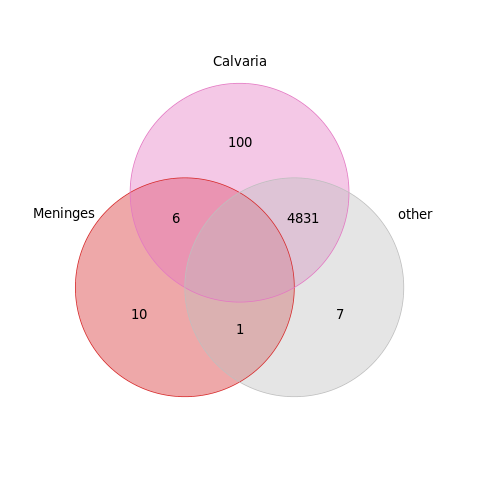

In [14]:
%%R -i df -i colors
colors = unlist(colors)
venn(df, zcolor=colors, col=colors, opacity=0.40, box=FALSE, ilcs = 1.1, sncs = 1.1)

In [15]:
%%R -i df -i colors
save_venn(df,colors,"./figures/neutrophils_venn_Naive.pdf")

NULL
[1] 2


In [17]:
df = get_venn_df("Sham",pool_regions={"other":["Pelvis","Femur","Humerus"]},
            celltypes=["pre neutrophil","immature neutrophil","mature neutrophil"],
            pval=0.05,LFC=0.5,full_info=False)

colors = [colors_dict[col] for col in df.columns]

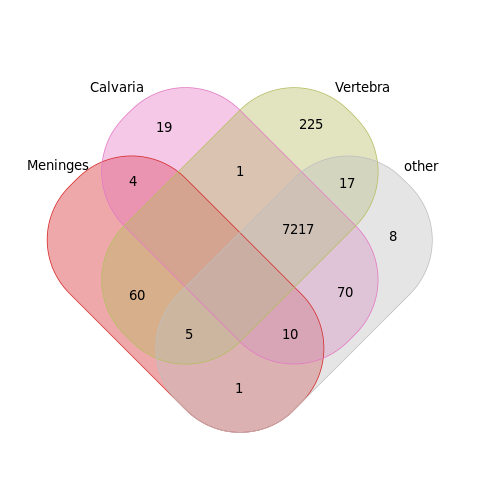

In [18]:
%%R -i df -i colors
colors = unlist(colors)
venn(df, zcolor=colors, col=colors, opacity=0.40, box=FALSE, ilcs = 1.1, sncs = 1.1)#, zcolor = cs, opacity=0.45,  box=FALSE, col=cs) # z_colors='style'

In [19]:
%%R -i df -i colors
save_venn(df,colors,"./figures/neutrophils_venn_Sham.pdf")

NULL
[1] 2


In [20]:
df = get_venn_df("MCAO",pool_regions={"other":["Vertebra","Pelvis","Femur","Humerus"]},
            celltypes=["pre neutrophil","immature neutrophil","mature neutrophil"],
            pval=0.05,LFC=0.5,full_info=False)

colors = [colors_dict[col] for col in df.columns]

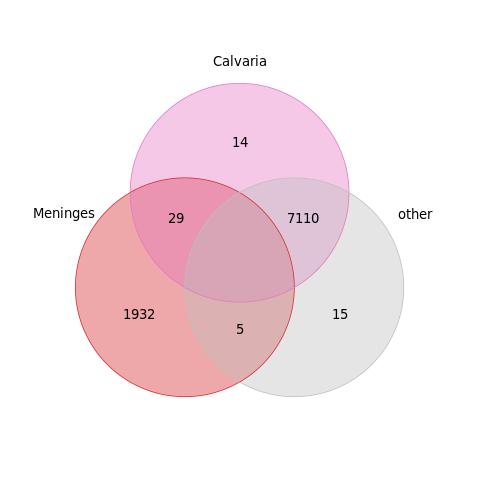

In [21]:
%%R -i df -i colors
colors = unlist(colors)
venn(df, zcolor=colors, col=colors, opacity=0.40, box=FALSE, ilcs = 1.1, sncs = 1.1)

In [22]:
%%R -i df -i colors
save_venn(df,colors,"./figures/neutrophils_venn_MCAO.pdf")

NULL
[1] 2


### Matrix plots for genes shared upregulated with meninges

In [24]:
from matplotlib.colors import ListedColormap

def heatmap_df(df,adata,condition="Naive",regions=["Meninges","Skull","Vertebra","Femur","Humerus","Pelvis"]):
    """Calculate mean expressions
    
    df: pd.DataFrame
        has the genes of interest in index and the celltype of interest in df["celltype"]. That's actually all we need.
        
    Returns
    -------
    df with mean expressions for regions, cell type info, and combination index
    """
    ct_key = "level2"
  
    df_hm = df[["celltype","combination"]].copy()
    # Calculate mean expressions per cell type
    for ct in df_hm["celltype"].unique():
        for r in regions:
            filt = (adata.obs["condition"] == condition) & (adata.obs["region"] == r) & (adata.obs[ct_key] == ct)
            genes = df_hm.loc[df_hm["celltype"]==ct].index
            a = adata[filt,genes]
            #if a.n_obs > 1: # Actually we shouldn't need this! Was only in there because I head the group "other" frp,
            means = a.X.mean(axis=0,dtype=np.float64)
            means = np.asarray(means[-1]).reshape(-1) if issparse(a.X) else means[-1]
            #else:
            #    means = np.zeros(len(genes))
            df_hm.loc[df_hm["celltype"]==ct,r] = means
    
    # Scale mean expressions to min-max 1-0
    df_hm_scaled = df_hm.copy()
    df_hm_scaled[regions] = df_hm_scaled[regions].values - df_hm_scaled[regions].min(axis=1).values[:,np.newaxis]
    df_hm_scaled[regions] = df_hm_scaled[regions].values / df_hm_scaled[regions].max(axis=1).values[:,np.newaxis]  
    
    df_hm_scaled = df_hm_scaled.rename(columns={"Skull":"Calvaria"})
    
    return df_hm_scaled
    
def DE_heatmap(df_hm_scaled,adata,figsize=(4,10),show=True,save=False,dpi=200,reverse_df=False):    

    ct_key="level2"
    
    if "Calvaria" in df_hm_scaled.columns:
        bones = np.array(["Meninges",'Calvaria', 'Vertebra', 'Humerus', 'Femur', 'Pelvis'])
    else:
        bones = np.array(["Meninges",'Skull', 'Vertebra', 'Humerus', 'Femur', 'Pelvis'])
    #bones = np.array(['Skull', 'Vertebra', 'Scapula', 'Humerus', 'Femur', 'Pelvis'])#['Skull', 'Pelvis', 'Femur', 'Vertebra', 'Humerus', 'Scapula'])
    
    if reverse_df:
        df_hm_scaled = df_hm_scaled[::-1].copy()
    
    # Prepare Colors 
    # For combinations    
    combination_colors = {}
        #"skull_only" : adata.uns["region_colors"][adata.obs["region"].cat.categories.tolist().index("Skull")],
        #"vertebra_only" : adata.uns["region_colors"][adata.obs["region"].cat.categories.tolist().index("Vertebra")],
        #"femur_only" : adata.uns["region_colors"][adata.obs["region"].cat.categories.tolist().index("Femur")],
        #"skull_vertebra" : "purple",
        #"not_skull" : "grey",
        #"not_vertebra" : "blue",
        ##"not_scapula" : "brown",
        #"all_bones" : "gold",
        
    if 6 in df_hm_scaled["combination"].unique():
        combination_colors.update(
            #{"Skull" : adata.uns["region_colors"][adata.obs["region"].cat.categories.tolist().index("Skull")]}
            {"Calvaria" : adata.uns["region_colors"][adata.obs["region"].cat.categories.tolist().index("Skull")]}
        )
    if 9 in df_hm_scaled["combination"].unique():
        combination_colors.update(
            {"Vertebra" : adata.uns["region_colors"][adata.obs["region"].cat.categories.tolist().index("Vertebra")]}
        )        
    if not df_hm_scaled["combination"].isin([6,9]).all():
        combination_colors.update(
            {"other" : "grey"}
        )        
    
    
    #combination_colors = {comb:color for comb,color in combination_colors.items() if comb in df_hm_scaled["combination"].unique()}
    combs_color_order = [key for key in combination_colors]
    combs_colors = [color for _,color in combination_colors.items()]
    if reverse_df:
        combs_color_order = combs_color_order[::-1] 
        combs_colors = combs_colors[::-1]
    # For cell types    
    cats = []
    ct_colors = []
    for i, cat in enumerate(adata.obs[ct_key].cat.categories):
        cats.append(cat)
        ct_colors.append(adata.uns[f"{ct_key}_colors"][i])
    # Columns for color codes
    df_hm_scaled["celltype_idx"] = df_hm_scaled["celltype"].apply(lambda x: cats.index(x))
    combs_order = df_hm_scaled["combination"].unique().tolist()
    df_hm_scaled["combination_idx"] = df_hm_scaled["combination"].apply(lambda x: combs_order.index(x))
    ct_colors = ct_colors[df_hm_scaled["celltype_idx"].min():df_hm_scaled["celltype_idx"].max()+1]
    
    # Plot
    fig = plt.figure(figsize=figsize)
    ax1 = plt.subplot2grid((3,10), (0,0), rowspan=3, colspan= 1) # ((3,15), (0,0), rowspan=3, colspan= 1))
    ax2 = plt.subplot2grid((3,10), (0,1), rowspan=3, colspan= 1) # ((3,15), (0,1), rowspan=3, colspan= 1))
    ax3 = plt.subplot2grid((3,10), (0,2), rowspan=3, colspan= 7) # ((3,15), (0,2), rowspan=3, colspan=12)) 1.5 per bone = 1.5 * 5 = 6.5 ~ 7
    #ax4 = plt.subplot2grid((3,10), (2,9), rowspan=1, colspan= 1) # ((3,15), (2,14), rowspan=1, colspan=1))
    
    sns.heatmap(df_hm_scaled[["combination_idx"]],ax=ax1,cbar=False,cmap=ListedColormap(combs_colors))
    df_hm_scaled["counter"] = [i for i in range(len(df_hm_scaled))]
    combinations = df_hm_scaled["combination"].unique().tolist()
    d = df_hm_scaled
    yticks = [(d.loc[d["combination"] == comb,"counter"].min()+d.loc[d["combination"] == comb,"counter"].max())/2 for comb in combinations]
    ax1.axes.yaxis.set_visible(False)    
    #ax1.set_yticks(yticks)#[np.sum(df_L_scaled["combination"] == "skull_only")/2])
    #ax1.set_yticklabels(combinations)
    ax1.set_xticklabels(["group"], rotation=90)
    sns.heatmap(df_hm_scaled[["celltype_idx"]],cmap=ListedColormap(ct_colors),ax=ax2,cbar=False)
    
    #ax2.axes.xaxis.set_visible(False)
    ax2.axes.yaxis.set_visible(False)
    ax2.set_xticklabels(["cell type"], rotation=90)
    hm = sns.heatmap(df_hm_scaled[bones],cmap="copper",ax=ax3,cbar=False)#,cbar=True,cbar_ax=ax4)
    ax3.axes.yaxis.set_visible(True)#False) 
    ax3.yaxis.tick_right()
    ax3.yaxis.set_label_position("right")
    ax3.yaxis.set_tick_params(rotation=180)
    #ax3.set_yticklabels(df_hm_scaled.index.tolist(), rotation = 0)
    #ax2.set_yticklabels(["cell type"], rotation=90)
    ax3.xaxis.set_tick_params(rotation=90)
    
    if show:
        plt.show()
    if save:
        fig.savefig(save, dpi=dpi, bbox_inches = "tight")
    plt.close()

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors

plt.rcParams['figure.dpi'] = 150
SMALL_SIZE = 17
MEDIUM_SIZE = 19
BIGGER_SIZE = 21
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


In [26]:
def get_filter(df,cols=["Meninges","Skull","other"],combs=[[1,1,0],[1,0,1]]):
    """
    """
    filt = False
    for comb in combs:
        filt_tmp = True
        for col,val in zip(cols,comb):
            filt_tmp = filt_tmp & (df[col] == val)
        filt = filt | filt_tmp    
        
    return filt

In [31]:
df = get_venn_df("Naive",pool_regions={"other":["Vertebra","Pelvis","Femur","Humerus"]},
            celltypes=["pre neutrophil","immature neutrophil","mature neutrophil"],
            pval=0.05,LFC=0.5,full_info=True)

filt = get_filter(df,cols=["Meninges","Calvaria","other"],#cols=["Meninges","Skull","other"],
                  combs=[[1,1,0],[1,0,1]])

df = df.loc[filt]
df["ct_rank"] = 0
for c in df["combination"].unique():
    for i,ct in enumerate(df.loc[df["combination"]==c,"celltype"].value_counts().index):
        df.loc[(df["combination"]==c) & (df["celltype"]==ct),"ct_rank"] = i
df = df.sort_values(["combination","ct_rank","pvals"],ascending=[True,True,True])

/opt/python/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


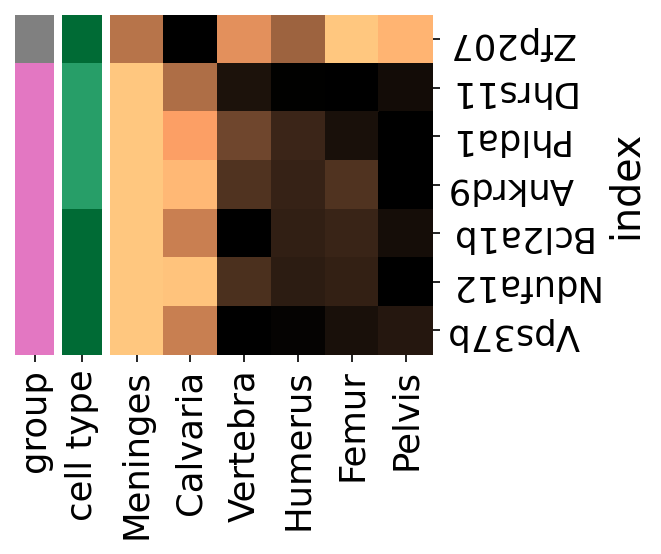

In [32]:
df_hm_scaled = heatmap_df(df,adata,condition="Naive",regions=["Meninges","Skull","Vertebra","Femur","Humerus","Pelvis"])
DE_heatmap(df_hm_scaled,adata,figsize=(4,3),show=True,save="./figures/neutro_DE/Naive.png",dpi=200,reverse_df=True)#

In [33]:
df = get_venn_df("Sham",pool_regions={"other":["Pelvis","Femur","Humerus"]},
            celltypes=["pre neutrophil","immature neutrophil","mature neutrophil"],
            pval=0.05,LFC=0.5,full_info=True)

filt = get_filter(df,cols=["Meninges","Calvaria","Vertebra","other"],#cols=["Meninges","Skull","Vertebra","other"],
                  combs=[[1,1,0,0],[1,0,1,0],[1,0,0,1]])

df = df.loc[filt]
df["ct_rank"] = 0
for c in df["combination"].unique():
    for i,ct in enumerate(df.loc[df["combination"]==c,"celltype"].value_counts().index):
        df.loc[(df["combination"]==c) & (df["celltype"]==ct),"ct_rank"] = i
df = df.sort_values(["combination","ct_rank","pvals"],ascending=[True,True,True])

/opt/python/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


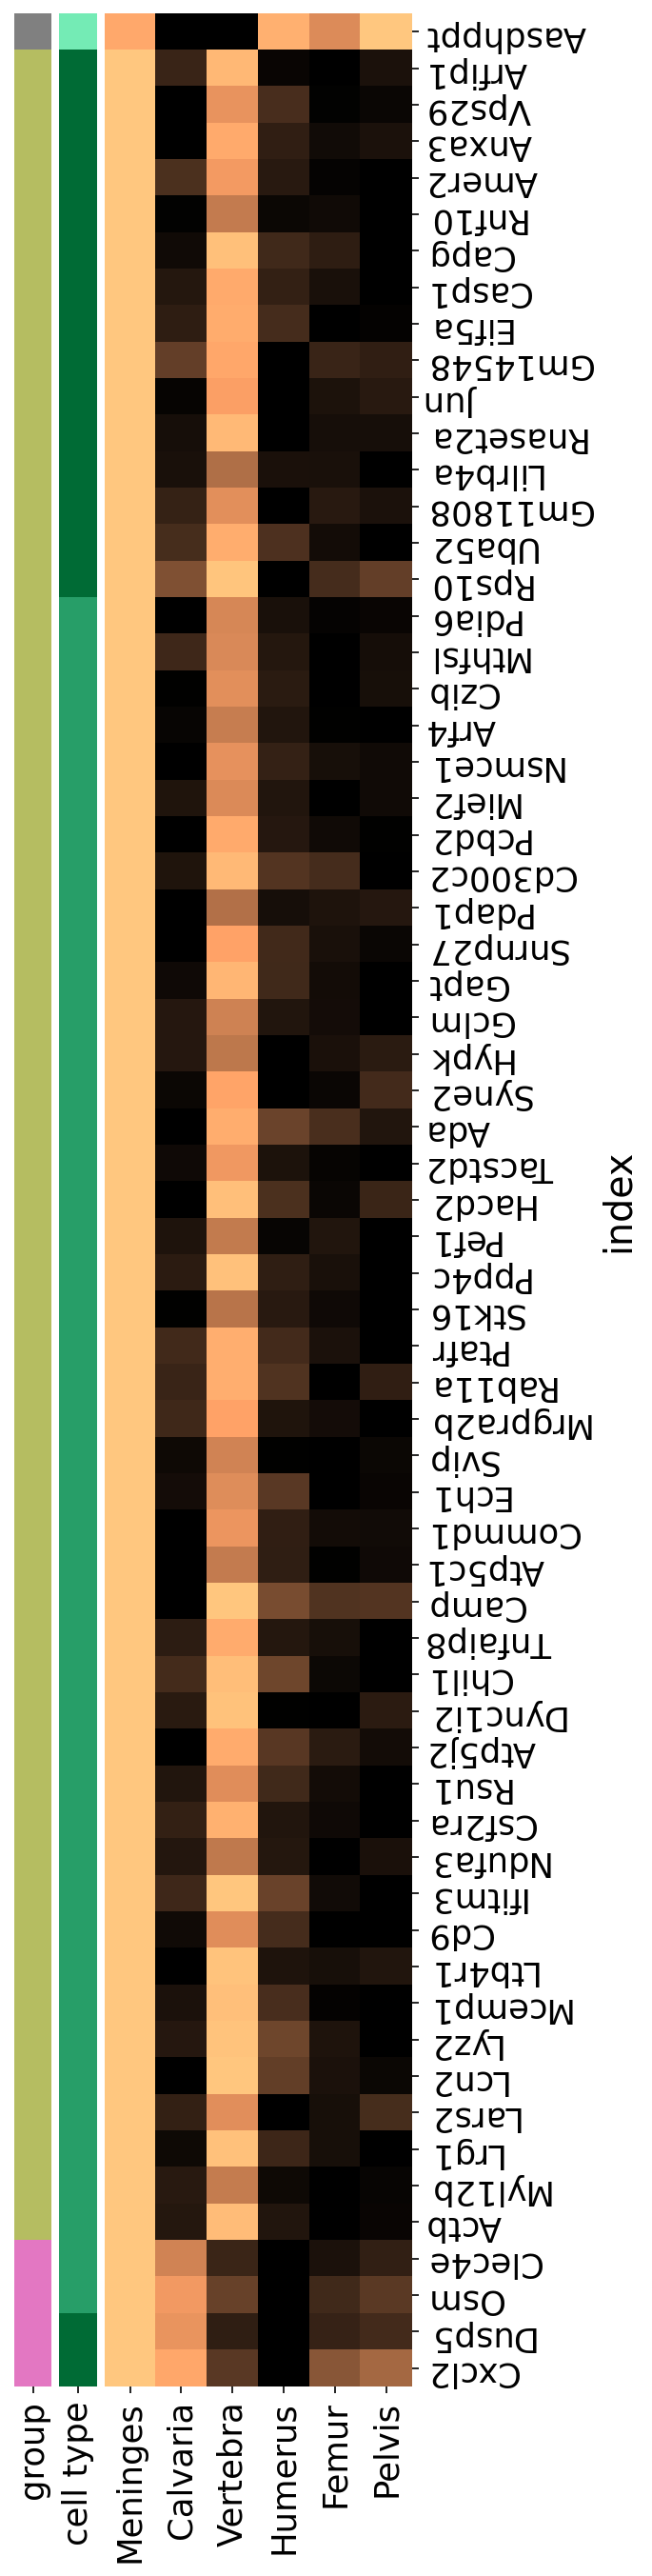

In [34]:
df_hm_scaled = heatmap_df(df,adata,condition="Sham",regions=["Meninges","Skull","Vertebra","Femur","Humerus","Pelvis"])
DE_heatmap(df_hm_scaled,adata,figsize=(4,22),show=True,save="./figures/neutro_DE/Sham.png",dpi=200,reverse_df=True)

In [35]:
df = get_venn_df("MCAO",pool_regions={"other":["Vertebra","Pelvis","Femur","Humerus"]},
            celltypes=["pre neutrophil","immature neutrophil","mature neutrophil"],
            pval=0.05,LFC=0.5,full_info=True)

filt = get_filter(df,cols=["Meninges","Calvaria","other"],#cols=["Meninges","Skull","other"],
                  combs=[[1,1,0],[1,0,1]])

df = df.loc[filt]
df["ct_rank"] = 0
for c in df["combination"].unique():
    for i,ct in enumerate(df.loc[df["combination"]==c,"celltype"].value_counts().index):
        df.loc[(df["combination"]==c) & (df["celltype"]==ct),"ct_rank"] = i
df = df.sort_values(["combination","ct_rank","pvals"],ascending=[True,True,True])

In [ ]:
df_hm_scaled = heatmap_df(df,adata,condition="MCAO",regions=["Meninges","Skull","Vertebra","Femur","Humerus","Pelvis"])
DE_heatmap(df_hm_scaled,adata,figsize=(4,11),show=True,save="./figures/neutro_DE/MCAO.png",dpi=200,reverse_df=True)

/opt/python/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [89]:
dfs = {}
for cond in ["Naive","Sham","MCAO"]:
    dfs[cond] = get_mean_diff_based_df(
        adata,ct_key="level2",conditions=[cond],min_cells_per_bone=5,verbosity=2,
        bones=np.array(['Meninges','Skull', 'Pelvis', 'Femur', 'Vertebra', 'Humerus']),
        pool_bones={"other":['Pelvis', 'Femur', 'Vertebra', 'Humerus']}
    )

cell types:   0%|          | 0/3 [00:00<?, ?it/s]

test1: bone groups combinations:   0%|          | 0/6 [00:00<?, ?it/s]

test2: low high combinations:   0%|          | 0/6 [00:00<?, ?it/s]

test1: bone groups combinations:   0%|          | 0/6 [00:00<?, ?it/s]

test2: low high combinations:   0%|          | 0/6 [00:00<?, ?it/s]

test1: bone groups combinations:   0%|          | 0/6 [00:00<?, ?it/s]

test2: low high combinations:   0%|          | 0/6 [00:00<?, ?it/s]

cell types:   0%|          | 0/3 [00:00<?, ?it/s]

test1: bone groups combinations:   0%|          | 0/6 [00:00<?, ?it/s]

test2: low high combinations:   0%|          | 0/6 [00:00<?, ?it/s]

test1: bone groups combinations:   0%|          | 0/6 [00:00<?, ?it/s]

test2: low high combinations:   0%|          | 0/6 [00:00<?, ?it/s]

test1: bone groups combinations:   0%|          | 0/6 [00:00<?, ?it/s]

test2: low high combinations:   0%|          | 0/6 [00:00<?, ?it/s]

cell types:   0%|          | 0/4 [00:00<?, ?it/s]

test1: bone groups combinations:   0%|          | 0/6 [00:00<?, ?it/s]

test2: low high combinations:   0%|          | 0/6 [00:00<?, ?it/s]

test1: bone groups combinations:   0%|          | 0/6 [00:00<?, ?it/s]

test2: low high combinations:   0%|          | 0/6 [00:00<?, ?it/s]

test1: bone groups combinations:   0%|          | 0/6 [00:00<?, ?it/s]

test2: low high combinations:   0%|          | 0/6 [00:00<?, ?it/s]

test1: bone groups combinations:   0%|          | 0/6 [00:00<?, ?it/s]

test2: low high combinations:   0%|          | 0/6 [00:00<?, ?it/s]

In [93]:
combinations = {
    "0":"Meninges",
    "1":"Skull",
    "2":"other bones",
    "3":"Meninges + Skull",
    "4":"Meninges + other bones", 
    "5":"Skull + other bones", 
}

In [94]:
for LF_th in [0.5,1.0,2.0]:
    print(f"######### logfoldchanges th: {LF_th} #########")
    dfs2 = {}
    for cond in ["Naive","Sham","MCAO"]:
        df = dfs[cond]
        dfs2[cond] = df[(df["pvals_adj"] < 0.05) & (df["logfoldchanges"] > LF_th)]
        tmp = pd.DataFrame(dfs2[cond]["combination"].value_counts())
        tmp["name"] = tmp.index.map(lambda x: combinations[str(x)] if str(x) in combinations else "?")
        print(f"###~~~ {cond} ~~~###")
        display(tmp)

######### logfoldchanges th: 0.5 #########
###~~~ Naive ~~~###


combination                    name
5         7939     Skull + other bones
2         2151             other bones
1          174                   Skull
4          152  Meninges + other bones
3           23        Meninges + Skull
0           15                Meninges

###~~~ Sham ~~~###


combination                    name
5        11813     Skull + other bones
2         2221             other bones
4          102  Meninges + other bones
1           36                   Skull
3           16        Meninges + Skull

###~~~ MCAO ~~~###


combination                    name
5        10524     Skull + other bones
0         2301                Meninges
2         1637             other bones
4          292  Meninges + other bones
3           60        Meninges + Skull
1           20                   Skull

######### logfoldchanges th: 1.0 #########
###~~~ Naive ~~~###


combination                    name
5         7026     Skull + other bones
2         1909             other bones
4          114  Meninges + other bones
1           99                   Skull
3            7        Meninges + Skull
0            5                Meninges

###~~~ Sham ~~~###


combination                    name
5        10460     Skull + other bones
2         2086             other bones
4           54  Meninges + other bones
1           17                   Skull
3            6        Meninges + Skull

###~~~ MCAO ~~~###


combination                    name
5         8644     Skull + other bones
2         1379             other bones
0         1029                Meninges
4          132  Meninges + other bones
3           28        Meninges + Skull
1            6                   Skull

######### logfoldchanges th: 2.0 #########
###~~~ Naive ~~~###


combination                    name
5         5832     Skull + other bones
2         1179             other bones
4           78  Meninges + other bones
1           26                   Skull

###~~~ Sham ~~~###


combination                    name
5         9102     Skull + other bones
2         1439             other bones
4           30  Meninges + other bones
1            3                   Skull

###~~~ MCAO ~~~###


combination                    name
5         5943     Skull + other bones
2         1019             other bones
0          306                Meninges
4           48  Meninges + other bones
3           10        Meninges + Skull
1            3                   Skull

In [ ]:
combinations = {
    "0":"Meninges",
    "1":"Skull",
    "2":"other bones",
    "3":"Meninges + Skull",
    "4":"Meninges + other bones", 
    "5":"Skull + other bones", 
}

In [92]:
dfs["MCAO"].loc[~dfs["MCAO"]["combination"].isin([0,2,5])]

celltype Meninges Skull other    low   high  combination  \
index                                                                           
Gm37988     mature neutrophil        0     1     0  other  Skull            1   
Pcmtd1      mature neutrophil        1     1     0  other  Skull            3   
Cspp1       mature neutrophil        0     1     0  other  Skull            1   
Terf1       mature neutrophil        1     0     1  Skull  other            4   
Rdh10       mature neutrophil        1     1     0  other  Skull            3   
...                       ...      ...   ...   ...    ...    ...          ...   
Fam204a        pro neutrophil        0     1     0  other  Skull            1   
AC133103.1     pro neutrophil        0     1     0  other  Skull            1   
AC132444.1     pro neutrophil        0     1     0  other  Skull            1   
Csprs          pro neutrophil        0     1     0  other  Skull            1   
AC149090.1     pro neutrophil        1     1     0  other  Skull            3   

            permutation     pvals  pvals_adj    scores  logfoldchanges  
index                                                                   
Gm37988               5  0.336306   0.565054  0.961596        2.024765  
Pcmtd1                5  0.030041   0.242421  2.170056        0.210176  
Cspp1                 5  0.502139   0.622527  0.671168        0.059208  
Terf1                 3  0.428959   0.456291  0.790988        0.088536  
Rdh10                 5  0.155498   0.523730  1.420557        0.333772  
...                 ...       ...        ...       ...             ...  
Fam204a               5  0.134788   0.669451  1.500842        0.430919  
AC133103.1            5  0.487203   0.669451  0.696319        2.130270  
AC132444.1            5  0.319392   0.669451  1.000000       22.026705  
Csprs                 5  0.248804   0.669451  1.157167        1.971281  
AC149090.1            5  0.372484   0.669451  0.893559        0.195745  

[9244 rows x 12 columns]

# Plot Meninges and Calvaria cells

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors

plt.rcParams['figure.dpi'] = 150
SMALL_SIZE = 17
MEDIUM_SIZE = 19
BIGGER_SIZE = 21
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


In [28]:
adata = sc.read(DATA_DIR+f'cellxgene_{DATA_VERSION}{sham_str}_umaps.h5ad')
adata = adata[adata.obs["level1"] == "neutrophil"]

In [29]:
adata.obs["region"] = adata.obs["region"].cat.rename_categories({'Skull': 'Calvaria'})

Trying to set attribute `.obs` of view, copying.


In [30]:
adata.obs["Calvaria and Meninges"] = adata.obs["region"].apply(lambda x: x if x in ["Calvaria", "Meninges"] else "other")

In [32]:
color_map = {
    "Meninges" : '#d62728',
    "Calvaria" : '#e377c2',
    "other"    : '#d3d3d3',
}

adata.obs["Calvaria and Meninges"] = adata.obs["Calvaria and Meninges"].astype("category")

adata.uns['Calvaria and Meninges_colors'] = [color_map[r] for r in adata.obs["Calvaria and Meninges"].cat.categories]

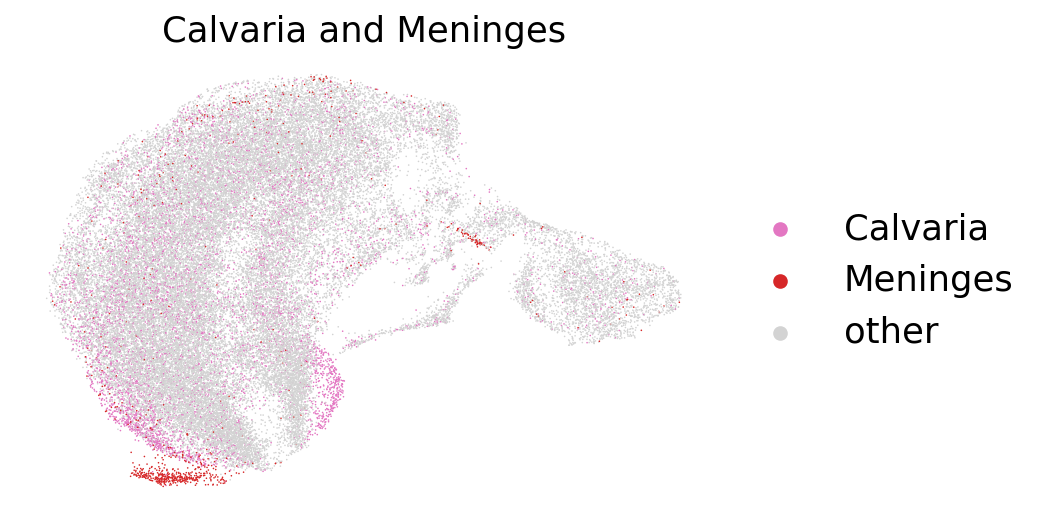

In [33]:
sc.pl.embedding(adata,"X_umap_neutrophils",color="Calvaria and Meninges",frameon=False)